In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import cartopy.crs as ccrs
# import xbpch
from scipy import stats
from tabulate import tabulate
import seaborn as sns
import bambi as bmb
import pymc as pm
from cartopy.util import add_cyclic_point
from textwrap import wrap

In [2]:
# Read in the data file which is currently stored on Becky's Cindylou server in Ursula Jongebloed's folder
# You'll have to change this to your folder when you are working with these data
sulfate_samples = pd.read_excel('./Data/greenland_sulfate_samples.xls')
patris_data = pd.read_csv('./Data/PatrisDatasimple.csv')
mainfig = pd.read_excel('./Data/Main_Fig_Data.xlsx')
# Dropping sample 36 because the d34S values is four standard deviations above mean preindustrial measurement
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.sample_no==36].index)
#Jihong says this is contaminated
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1819].index)
# This sample is creating weird results, might add back in later
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1864].index)
# Based on reviewer comments, dropping 1229, 1253, 1272, 1292, 1342, 1345, 1461, 1638, and 1822
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1229].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1253].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1272].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1292].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1342].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1345].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1461].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1638].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1822].index)
sulfate_samples = sulfate_samples.drop(sulfate_samples[sulfate_samples.first_year==1864].index)
index2 = pd.Series(np.arange(0,1857,1))
sulfate_samples = sulfate_samples.set_index(index2)

In [3]:
# Define all of the sample variables that are in the dataset

# first standards: baso4, ag2s, zns, na2so4
baso4_all = sulfate_samples[sulfate_samples.mat=='baso4']
baso4_gdi = baso4_all.where(baso4_all.flag==1)
baso4_bdi = baso4_all.where(baso4_all.flag==0)

ag2s_all = sulfate_samples[sulfate_samples.mat=='ag2s']
ag2s_gdi = ag2s_all.where(ag2s_all.flag==1)
ag2s_bdi = ag2s_all.where(ag2s_all.flag==0)

zns_all = sulfate_samples[sulfate_samples.mat=='zns']
zns_gdi = zns_all.where(zns_all.flag==1)
zns_bdi = zns_all.where(zns_all.flag==0)

na2so4_all = sulfate_samples[sulfate_samples.mat=='na2so4']
na2so4_gdi = na2so4_all.where(na2so4_all.flag==1)
na2so4_bdi = na2so4_all.where(na2so4_all.flag==0)

# IAEA standards

iaeas1_all = sulfate_samples[sulfate_samples.mat=='IAEA-S-1']
iaeas1_good = iaeas1_all.where(iaeas1_all.flag==1)
iaeas1_bad = iaeas1_all.where(iaeas1_all.flag==0)

iaeas2_all = sulfate_samples[sulfate_samples.mat=='IAEA-S-2']
iaeas2_good = iaeas2_all.where(iaeas2_all.flag==1)
iaeas2_bad = iaeas2_all.where(iaeas2_all.flag==0)

iaeas3_all = sulfate_samples[sulfate_samples.mat=='IAEA-S-3']
iaeas3_good = iaeas3_all.where(iaeas3_all.flag==1)
iaeas3_bad = iaeas3_all.where(iaeas3_all.flag==0)

iaeas4_all = sulfate_samples[sulfate_samples.mat=='IAEA-S-4']
iaeas4_good = iaeas4_all.where(iaeas4_all.flag==1)
iaeas4_bad = iaeas4_all.where(iaeas4_all.flag==0)

iaeas5_all = sulfate_samples[sulfate_samples.mat=='IAEA-S-5']
iaeas5_good = iaeas5_all.where(iaeas5_all.flag==1)
iaeas5_bad = iaeas5_all.where(iaeas5_all.flag==0)

iaeas6_all = sulfate_samples[sulfate_samples.mat=='IAEA-S-6']
iaeas6_good = iaeas6_all.where(iaeas6_all.flag==1)
iaeas6_bad = iaeas6_all.where(iaeas6_all.flag==0)

nbs127_all = sulfate_samples[sulfate_samples.mat=='NBS_127']
nbs127_good = nbs127_all.where(nbs127_all.flag==1)
nbs127_bad = nbs127_all.where(nbs127_all.flag==0)

# empty tins, process standards, and process blanks
empty_tin_all = sulfate_samples[sulfate_samples.mat=='empty_tin']
empty_tin_gdi = empty_tin_all.where(empty_tin_all.flag==1)
empty_tin_bdi = empty_tin_all.where(empty_tin_all.flag==0)

empty_quartz_filter = sulfate_samples[sulfate_samples.mat=='empty_quartz_filter'].where(sulfate_samples.flag==1)
process_std = sulfate_samples[sulfate_samples.mat=='process_std'].where(sulfate_samples.flag==1)
process_blk = sulfate_samples[sulfate_samples.mat=='process_blk'].where(sulfate_samples.flag==1)
process_blk_wib  = sulfate_samples[sulfate_samples.mat=='process_blk'].where(sulfate_samples.flag==1)
process_blk_fict = sulfate_samples[sulfate_samples.mat=='process_blk'].where(sulfate_samples.flag==1)

# ice core samples
ice_core_sample_with_cont = sulfate_samples[sulfate_samples.mat=='ice_core_sample']
ice_core_sample = ice_core_sample_with_cont.loc[ice_core_sample_with_cont.first_year!=1652] #eliminate contaminated sample
ice_year = ice_core_sample['first_year']
ice_core_sample_old = ice_core_sample.where(ice_year < 1600)
ice_core_sample_pre = ice_core_sample.where(ice_year < 1850)
ice_core_sample_ind = ice_core_sample.where(ice_year > 1850)
duplicates = ice_core_sample.where(ice_core_sample.flag==2)

recent_run_date = sulfate_samples.startdate[np.shape(sulfate_samples)[0]-1]
recent_run = sulfate_samples[sulfate_samples.startdate==recent_run_date]

patris_preindustrial = patris_data[patris_data.MeanDate<1850]
patris_industrial = patris_data[patris_data.MeanDate>1850]

In [4]:
# define functions to calculate normalized peak area (npa), sample yield, and predicted S quantity (pSqty)
def npa(data):
    nparea = data['spa']*np.mean(sulfate_samples['rpa'])/data['rpa']
    return nparea

def nan_npa(data):
    data = data[data.Sqty>0]
    nparea = data['spa']*np.mean(sulfate_samples['rpa'])/data['rpa']
    return nparea

def sample_yield(data):
    sampyield = npa(data)/data['Sqty']
    return sampyield

def pSqty(data,slope):
    predSqty = npa(data)/slope
    return predSqty

In [5]:
# first calculate stats for all standards individually
s_baso4, i_baso4, r_baso4, p_baso4, stderr_baso4      = stats.linregress(baso4_gdi.Sqty[baso4_gdi.Sqty>0],
                                                                    nan_npa(baso4_gdi))
s_ag2s, i_ag2s, r_ag2s, p_ag2s, stderr_ag2s           = stats.linregress(ag2s_gdi.Sqty[ag2s_gdi.Sqty>0],
                                                                    nan_npa(ag2s_gdi))
s_zns, i_zns, r_zns, p_zns, stderr_zns                = stats.linregress(zns_gdi.Sqty[zns_gdi.Sqty>0],
                                                                    nan_npa(zns_gdi))
s_na2so4, i_na2so4, r_na2so4, p_na2so4, stderr_na2so4 = stats.linregress(na2so4_gdi.Sqty[na2so4_gdi.Sqty>0],
                                                                    nan_npa(na2so4_gdi))
s_process_std, i_process_std, r_process_std, p_process_std, stderr_process_std = stats.linregress(process_std.Sqty[process_std.Sqty>0],
                                                                    nan_npa(process_std))

# next calculate stats for all standards combined
all_Sqty = np.hstack([baso4_gdi.Sqty[baso4_gdi.Sqty>0],ag2s_gdi.Sqty[ag2s_gdi.Sqty>0],zns_gdi.Sqty[zns_gdi.Sqty>0],na2so4_gdi.Sqty[na2so4_gdi.Sqty>0]])
all_npa = np.hstack([nan_npa(baso4_gdi),nan_npa(ag2s_gdi),nan_npa(zns_gdi),nan_npa(na2so4_gdi)])
s_all, i_all, r_all, p_all, stderr_all = stats.linregress(all_Sqty, all_npa)

# now create y values for best fit lines
baso4_pred= baso4_gdi['Sqty']*s_baso4+i_baso4
ag2s_pred   = ag2s_gdi['Sqty']*s_ag2s+i_ag2s
zns_pred    = zns_gdi['Sqty']*s_zns+i_zns
na2so4_pred = na2so4_gdi['Sqty']*s_na2so4+i_na2so4

In [6]:
Sqty_d34S_std_ag2s = np.array([np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)<1].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>1].loc[pSqty(ag2s_gdi,s_ag2s)<=2].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>2].loc[pSqty(ag2s_gdi,s_ag2s)<=4].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>4].loc[pSqty(ag2s_gdi,s_ag2s)<=6].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>6].loc[pSqty(ag2s_gdi,s_ag2s)<=8].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>8].loc[pSqty(ag2s_gdi,s_ag2s)<=10].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>10].loc[pSqty(ag2s_gdi,s_ag2s)<=14].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>14].loc[pSqty(ag2s_gdi,s_ag2s)<=20].d34S.values),
                               np.std(ag2s_gdi.loc[pSqty(ag2s_gdi,s_ag2s)>20].d34S.values)])

Sqty_d34S_std_baso4 = np.array([np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)<1].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>1].loc[pSqty(baso4_gdi,s_baso4)<=2].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>2].loc[pSqty(baso4_gdi,s_baso4)<=4].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>4].loc[pSqty(baso4_gdi,s_baso4)<=6].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>6].loc[pSqty(baso4_gdi,s_baso4)<=8].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>8].loc[pSqty(baso4_gdi,s_baso4)<=10].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>10].loc[pSqty(baso4_gdi,s_baso4)<=14].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>14].loc[pSqty(baso4_gdi,s_baso4)<=20].d34S.values),
                               np.std(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)>20].d34S.values)])

Sqty_d34S_std_zns = np.array([np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)<1].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>1].loc[pSqty(zns_gdi,s_zns)<=2].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>2].loc[pSqty(zns_gdi,s_zns)<=4].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>4].loc[pSqty(zns_gdi,s_zns)<=6].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>6].loc[pSqty(zns_gdi,s_zns)<=8].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>8].loc[pSqty(zns_gdi,s_zns)<=10].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>10].loc[pSqty(zns_gdi,s_zns)<=14].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>14].loc[pSqty(zns_gdi,s_zns)<=20].d34S.values),
                               np.std(zns_gdi.loc[pSqty(zns_gdi,s_zns)>20].d34S.values)])

Sqty_d34S_std_na2so4 = np.array([np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)<1].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>1].loc[pSqty(na2so4_gdi,s_na2so4)<=2].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>2].loc[pSqty(na2so4_gdi,s_na2so4)<=4].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>4].loc[pSqty(na2so4_gdi,s_na2so4)<=6].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>6].loc[pSqty(na2so4_gdi,s_na2so4)<=8].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>8].loc[pSqty(na2so4_gdi,s_na2so4)<=10].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>10].loc[pSqty(na2so4_gdi,s_na2so4)<=14].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>14].loc[pSqty(na2so4_gdi,s_na2so4)<=20].d34S.values),
                               np.std(na2so4_gdi.loc[pSqty(na2so4_gdi,s_na2so4)>20].d34S.values)])

Sqty_d34S_std_process_std = np.array([np.std(process_std.loc[pSqty(process_std,s_process_std)<1].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>1].loc[pSqty(process_std,s_all)<=2].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>2].loc[pSqty(process_std,s_all)<=4].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>4].loc[pSqty(process_std,s_all)<=6].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>6].loc[pSqty(process_std,s_all)<=8].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>8].loc[pSqty(process_std,s_all)<=10].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>10].loc[pSqty(process_std,s_all)<=14].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>14].loc[pSqty(process_std,s_all)<=20].d34S.values),
                               np.std(process_std.loc[pSqty(process_std,s_all)>20].d34S.values)])


/home/disk/p/ujongebl/miniconda3/envs/pymc_env/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/disk/p/ujongebl/miniconda3/envs/pymc_env/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/disk/p/ujongebl/miniconda3/envs/pymc_env/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
Sqty_d34S_std_process_size = np.array([np.shape(process_std.loc[pSqty(process_std,s_process_std)<1])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>1].loc[pSqty(process_std,s_all)<=2])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>2].loc[pSqty(process_std,s_all)<=4])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>4].loc[pSqty(process_std,s_all)<=6])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>6].loc[pSqty(process_std,s_all)<=8])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>8].loc[pSqty(process_std,s_all)<=10])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>10].loc[pSqty(process_std,s_all)<=14])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>14].loc[pSqty(process_std,s_all)<=20])[0],
                               np.shape(process_std.loc[pSqty(process_std,s_all)>20])[1]])


In [8]:
avg_error = np.nansum(Sqty_d34S_std_process_size*Sqty_d34S_std_process_std)/np.nansum(Sqty_d34S_std_process_size)
print('The mean error associated with all process standards is',avg_error)
measurement_error = np.zeros(len(ice_core_sample)) # create an empty array to store the measurement error
ice_year = ice_core_sample.first_year

# I CHANGED THIS TO ALL BE SQTY_D34S_PROCESS_STD[7] TO MAXIMIZE THE ERROR
for i in range(0,len(ice_core_sample)): # loop through all the ice core samples and assign an error based on pSqty
    if pSqty(ice_core_sample.iloc[[i]],s_all).values<=1:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>1 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=2:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>2 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=4:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>4 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=6:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>6 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=8:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>8 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=10:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>10 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=14:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>14 and pSqty(ice_core_sample.iloc[[i]],s_all).values<=20:
        measurement_error[i] = Sqty_d34S_std_process_std[7]
    elif pSqty(ice_core_sample.iloc[[i]],s_all).values>20:
        measurement_error[i] = Sqty_d34S_std_process_std[7]

# sample_error = measurement_error*1.96 # 95% confidence interval
sample_error = measurement_error*0+avg_error*1.96 # I'm starting to think that I should use average error as a more general error estimate bc I'm not sure that the error varies with size
sample_error_pre = sample_error[ice_year<1750]
sample_error_ind = sample_error[ice_year>1850]
dup_error=sample_error[ice_core_sample.flag==2]

The mean error associated with all process standards is 0.427514638936179


In [9]:
#s_all = 11.0630
# divide ice core samples into bins based on measured sulfur quantity
Sqty_1ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)<1] #making it zero because no ice core samples are of this size
Sqty_2ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>1].loc[pSqty(sulfate_samples,s_all)<=2]
Sqty_4ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>2].loc[pSqty(sulfate_samples,s_all)<=4]
Sqty_6ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>4].loc[pSqty(sulfate_samples,s_all)<=6]
Sqty_8ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>6].loc[pSqty(sulfate_samples,s_all)<=8]
Sqty_10ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>8].loc[pSqty(sulfate_samples,s_all)<=10]
Sqty_14ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>10].loc[pSqty(sulfate_samples,s_all)<=14]
Sqty_20ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>14].loc[pSqty(sulfate_samples,s_all)<=20]
Sqty_g20ug = sulfate_samples.loc[~np.isnan(sulfate_samples.d34S)].loc[pSqty(sulfate_samples,s_all)>20]

In [10]:
# the s_all that Andy calculated = 11.0630
# I took StdsKnwn_d34S from Andy's matlab code StdsKnwn_d34S = [ag2s.d34Sacc;baso4.d34Sacc]
# I plugged in the values for ag2s.d34Sacc and baso4.d34Sacc from Andy's matlab code
StdsKnwn_d34S = np.array([18.1400,5.0900])
StdsMeas_d34S_1ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)<=1].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_baso4)<1].d34S.values)];
StdsMeas_d34S_2ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>1].loc[pSqty(ag2s_gdi,s_all)<=2].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>1].loc[pSqty(baso4_gdi,s_all)<=2].d34S.values)];
StdsMeas_d34S_4ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>2].loc[pSqty(ag2s_gdi,s_all)<=4].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>2].loc[pSqty(baso4_gdi,s_all)<=4].d34S.values)];
StdsMeas_d34S_6ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>4].loc[pSqty(ag2s_gdi,s_all)<=6].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>4].loc[pSqty(baso4_gdi,s_all)<=6].d34S.values)];
StdsMeas_d34S_8ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>6].loc[pSqty(ag2s_gdi,s_all)<=8].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>6].loc[pSqty(baso4_gdi,s_all)<=8].d34S.values)];
StdsMeas_d34S_10ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>8].loc[pSqty(ag2s_gdi,s_all)<=10].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>8].loc[pSqty(baso4_gdi,s_all)<=10].d34S.values)];
StdsMeas_d34S_14ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>10].loc[pSqty(ag2s_gdi,s_all)<=14].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>10].loc[pSqty(baso4_gdi,s_all)<=14].d34S.values)];
StdsMeas_d34S_20ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>14].loc[pSqty(ag2s_gdi,s_all)<=20].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>14].loc[pSqty(baso4_gdi,s_all)<=20].d34S.values)];
StdsMeas_d34S_g20ug = [np.mean(ag2s_gdi.loc[pSqty(ag2s_gdi,s_all)>20].d34S.values),np.mean(baso4_gdi.loc[pSqty(baso4_gdi,s_all)>20].d34S.values)];

d34Sfit_1ug = np.polyfit(StdsMeas_d34S_1ug,StdsKnwn_d34S,1)
d34Sfit_2ug = np.polyfit(StdsMeas_d34S_2ug,StdsKnwn_d34S,1)
d34Sfit_4ug = np.polyfit(StdsMeas_d34S_4ug,StdsKnwn_d34S,1)
d34Sfit_6ug = np.polyfit(StdsMeas_d34S_6ug,StdsKnwn_d34S,1)
d34Sfit_8ug = np.polyfit(StdsMeas_d34S_8ug,StdsKnwn_d34S,1)
d34Sfit_10ug = np.polyfit(StdsMeas_d34S_10ug,StdsKnwn_d34S,1)
d34Sfit_14ug = np.polyfit(StdsMeas_d34S_14ug,StdsKnwn_d34S,1)
d34Sfit_20ug = np.polyfit(StdsMeas_d34S_20ug,StdsKnwn_d34S,1)
d34Sfit_g20ug = np.polyfit(StdsMeas_d34S_g20ug,StdsKnwn_d34S,1)

#change starting here

d34S_size_corrected = np.zeros(np.size(~np.isnan(sulfate_samples.d34S)))
d34S_size_corrected[Sqty_1ug.index.values] = d34Sfit_1ug[0]*Sqty_1ug.d34S+d34Sfit_1ug[1]
d34S_size_corrected[Sqty_2ug.index.values] = d34Sfit_2ug[0]*Sqty_2ug.d34S+d34Sfit_2ug[1]
d34S_size_corrected[Sqty_4ug.index.values] = d34Sfit_4ug[0]*Sqty_4ug.d34S+d34Sfit_4ug[1]
d34S_size_corrected[Sqty_6ug.index.values] = d34Sfit_6ug[0]*Sqty_6ug.d34S+d34Sfit_6ug[1]
d34S_size_corrected[Sqty_8ug.index.values] = d34Sfit_8ug[0]*Sqty_8ug.d34S+d34Sfit_8ug[1]
d34S_size_corrected[Sqty_10ug.index.values] = d34Sfit_10ug[0]*Sqty_10ug.d34S+d34Sfit_10ug[1]
d34S_size_corrected[Sqty_14ug.index.values] = d34Sfit_14ug[0]*Sqty_14ug.d34S+d34Sfit_14ug[1]
d34S_size_corrected[Sqty_20ug.index.values] = d34Sfit_20ug[0]*Sqty_20ug.d34S+d34Sfit_20ug[1]
d34S_size_corrected[Sqty_g20ug.index.values] = d34Sfit_g20ug[0]*Sqty_g20ug.d34S+d34Sfit_g20ug[1]

In [11]:
iaea_stdsknwn_d34S = np.array([22.6200,-32.4900,-34.0500,21.1200]) # iaeas2, iaeas3, iaeas6, nbs127 d34S values

iaeas1_d34Sacc = -0.3
iaeas2_d34Sacc = 22.62
iaeas3_d34Sacc = -32.49
iaeas4_d34Sacc = 16.90
iaeas5_d34Sacc = 0.49
iaeas6_d34Sacc = -34.05
nbs127_d34Sacc = 21.12

iaeas1_d34Smeas = d34S_size_corrected[iaeas1_good.index]
iaeas2_d34Smeas = d34S_size_corrected[iaeas2_good.index]
iaeas3_d34Smeas = d34S_size_corrected[iaeas3_good.index]
iaeas4_d34Smeas = d34S_size_corrected[iaeas4_good.index]
iaeas5_d34Smeas = d34S_size_corrected[iaeas5_good.index]
iaeas6_d34Smeas = d34S_size_corrected[iaeas6_good.index]
nbs127_d34Smeas = d34S_size_corrected[nbs127_good.index]

iaea_fit_vals = np.hstack([d34S_size_corrected[iaeas2_good.index],
                              d34S_size_corrected[iaeas3_good.index],
                              d34S_size_corrected[iaeas6_good.index],
                              d34S_size_corrected[nbs127_good.index]]
                            ) # measured standard values mean array

iaea_stdsmeas_d34S = np.array([np.mean(d34S_size_corrected[iaeas2_good.index]),
                              np.mean(d34S_size_corrected[iaeas3_good.index]),
                              np.mean(d34S_size_corrected[iaeas6_good.index]),
                              np.mean(d34S_size_corrected[nbs127_good.index])]
                            ) # measured standard values mean array
iaea_fit = np.polyfit(iaea_stdsmeas_d34S,iaea_stdsknwn_d34S,1) 

# d34S CORRECTED VALUES CALCULATED BELOW
d34S_VCDT = iaea_fit[0]*d34S_size_corrected+iaea_fit[1]

ag2s_d34Sacc = np.mean(d34S_VCDT[ag2s_gdi.index]) # 18.1400 in Andy's code?
baso4_d34Sacc = np.mean(d34S_VCDT[baso4_gdi.index]) #5.0900
zns_d34Sacc = np.mean(d34S_VCDT[zns_gdi.index]) #-33.7400
ag2s_d34Smeas = d34S_VCDT[ag2s_gdi.index]
baso4_d34Smeas = d34S_VCDT[baso4_gdi.index]
zns_d34Smeas = d34S_VCDT[zns_gdi.index]

In [12]:
# calculate the standard deviation of the process standards after they've been corrected for size and VCDT
process_std_std = np.std(d34S_VCDT[process_std.index])
process_std_std

1.2007042145148112

In [13]:
# First, add d34S_VCDT to the dataframe and then group by first year to get the mean d34S value for duplicates and triplicates
# nssSO4_forxl = pd.DataFrame(data=ice_core_sample.sulfate*(1-0.25*ice_core_sample.sodium/ice_core_sample.sulfate),index=ice_core_sample.index,columns={'nssSO4'})
VCDT = pd.DataFrame(data=d34S_VCDT[ice_core_sample.index],index=ice_core_sample.index,columns=['d34S_VCDT'])
sample_no = pd.DataFrame(data=ice_core_sample.sample_no,index=ice_core_sample.index,columns=['sample_no'])
# sample_error = pd.DataFrame(data=sample_error, index=ice_core_sample.index,columns={'sample_error'})
ice_core_withdup = pd.concat([ice_core_sample,VCDT],axis=1) # adding a column with VCDT correct values to the end of the ice core data array
ice_core = ice_core_withdup.groupby('first_year').mean() # This command averages the duplicates and triplicates into one sample

/tmp/ipykernel_30052/3973570048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ice_core = ice_core_withdup.groupby('first_year').mean() # This command averages the duplicates and triplicates into one sample


In [14]:
# Re-do all of the calculations from above but this time with each duplicate/triplicate represented by one sample instead of 2 or 3
ice_core = ice_core[ice_core.sulfate>3.5]
ice_years = ice_core.index
d34Sss = 21 # d34S of sea salt
fss = 0.25*(ice_core.sodium)/(ice_core.sulfate) # calculate the fraction of sea salt in each ice core sample
d34S = (ice_core.d34S_VCDT-d34Sss*fss)/(1-fss) # correct the d34S VCDT value for sea salt
d34S_prepre = d34S[ice_years<1750] # pre-preindustrial samples
d34S_pre = ((d34S[ice_years<1850])[ice_core.sulfate[ice_years<1850]<60])[ice_core.sulfate[ice_years<1850]>3.5] # sulfate conc <60 to eliminate volcanic eruptions
d34S_ind = (d34S[ice_years>1850])
d34S_old = (d34S[ice_years<1750])[ice_core.sulfate[ice_years<1750]<60]

d34S_nssSO4 = pd.DataFrame(data=d34S[ice_core.index],index=ice_core.index,columns=['d34S_nssSO4'])
ice_core = pd.concat([ice_core,d34S_nssSO4],axis=1)

nssSO4=ice_core.sulfate*(1-fss) # sulfate conc <60 to eliminate volcanic eruptions
nssSO4_prepre=nssSO4[nssSO4.index<1750] # pre-preindustrial samples
nssSO4_pre=((nssSO4[nssSO4.index<1850])[ice_core.sulfate[ice_years<1850]<60])[ice_core.sulfate[ice_years<1850]>3.5]
nssSO4_ind=((ice_core.sulfate*(1-fss))[ice_years>1850])

# Figure 1 from Jongebloed et al. (2023) ERL

n 61
p value 6.264337715143002e-15
r value 0.8038171973869901
Raw intercept is 3.62
The geometric mean intercept with patris samples is  2.92
The standard error associated with the industrial era linear regression  0.3


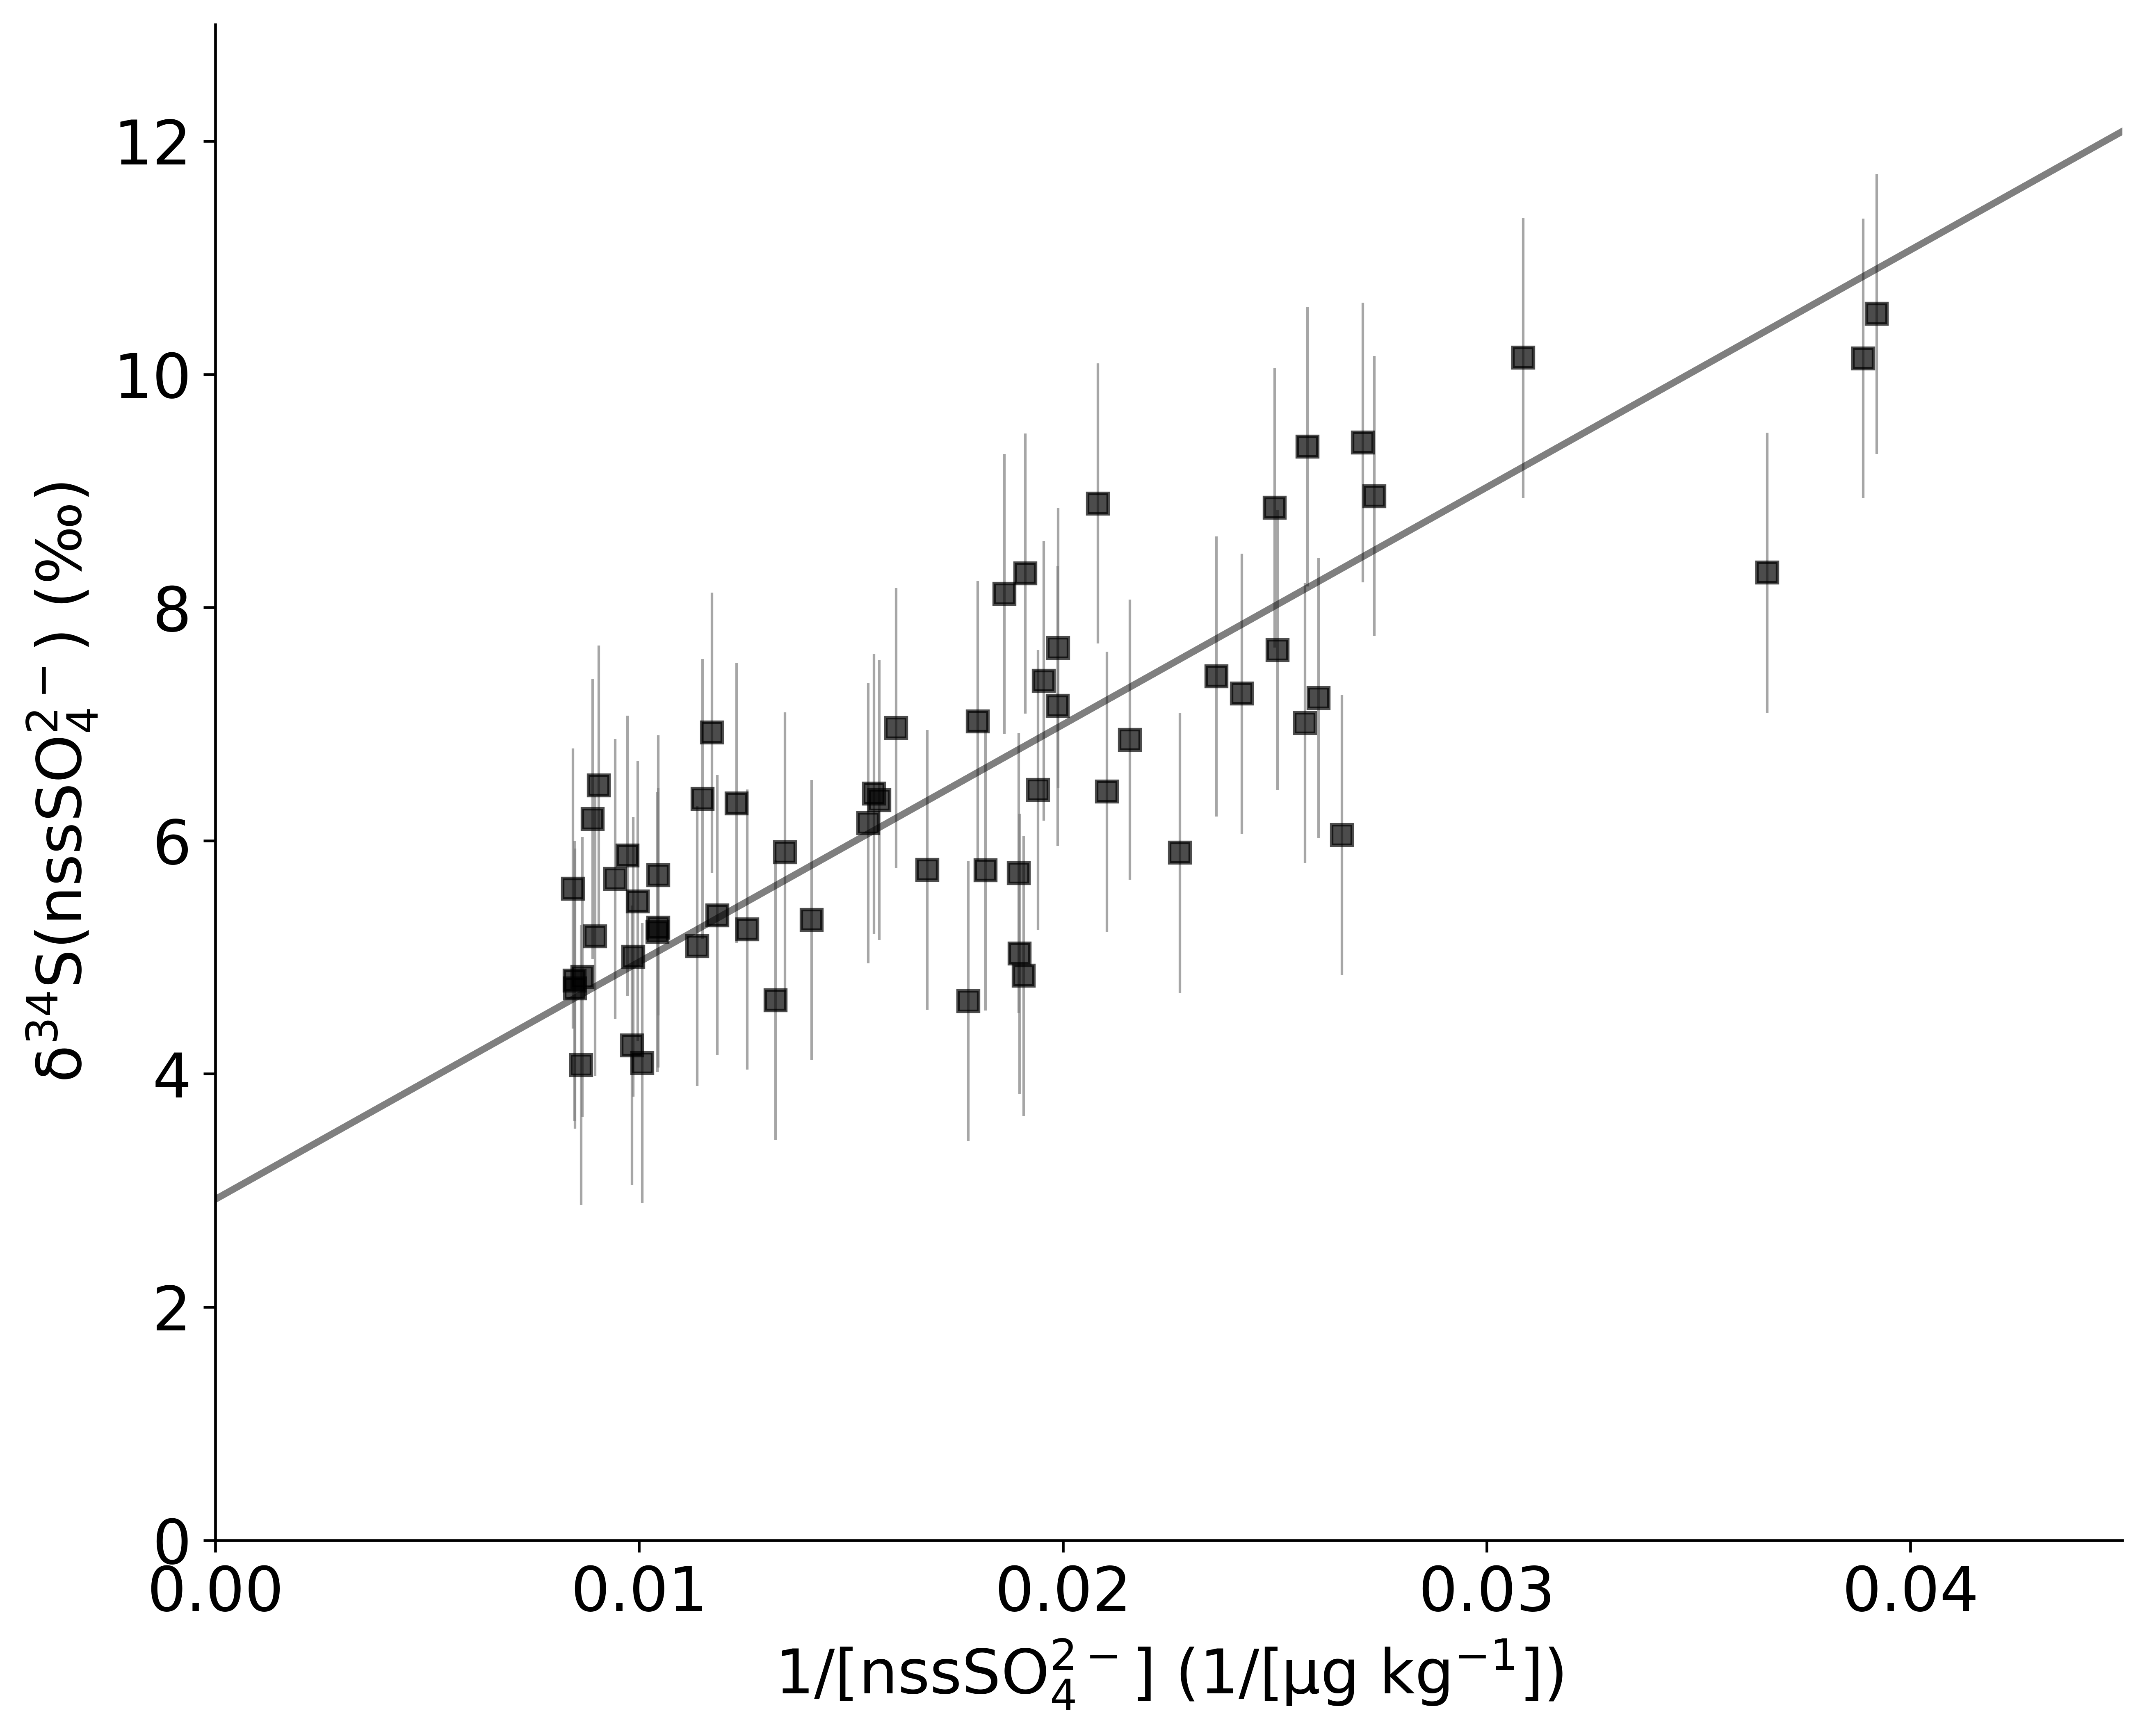

In [15]:
x = 1/np.hstack([nssSO4_ind[0:33],nssSO4_ind[36:40],nssSO4_ind[41:45],nssSO4_ind[48:]])
y = np.hstack([d34S_ind[0:33],d34S_ind[36:40],d34S_ind[41:45],d34S_ind[48:]])

# x = 1/nssSO4_ind
# y = d34S_ind
slope, intercept, r, p, stderr_slope = stats.linregress(x,y)
GM_slope = slope/r
gm_int = np.mean(y - GM_slope*x)
yhat = slope*x+intercept
Syx = np.sqrt(np.sum((y-yhat)**2)/(len(x)-2))
Sb_anth = Syx*np.sqrt(np.sum(x**2)/(len(x)*np.sum((x-np.mean(x))**2)))
print('n',len(x))
print('p value',p)
print('r value',r)
print('Raw intercept is',np.round(intercept,2))
print('The geometric mean intercept with patris samples is ',np.round(gm_int,2))
print('The standard error associated with the industrial era linear regression ',np.round(Sb_anth,2))
k = 18
i = np.linspace(0,0.08,50)
j = GM_slope*i+gm_int
fig,ax = plt.subplots(figsize = [10,8],dpi=600)
ax.set_ylabel('δ$^{34}$S(nssSO$_4^{2-}$) (‰)',fontsize=k)
ax.set_xlabel('1/[nssSO$_4^{2-}$] (µg kg$^{-1}$)',fontsize=k)
ax.tick_params(labelsize=k)
ax.tick_params(labelsize=k)

s=6
# plt.ylabel('δ$^{34}$S(nssSO$_4$$^{2-}$) (‰)',fontsize=k)
ax.set_xlabel('1/[nssSO$_4^{2-}$] (1/[µg kg$^{-1}$])',fontsize=k)
ax.errorbar(1/nssSO4_ind,d34S_ind,process_std_std,label='Ice core samples from 1850-2007',fmt='s',markersize=s,color='k',
             ecolor='gray',linewidth=0.75,alpha=0.7)
# ax.scatter(1/patris02_pd_nssSO4,patris02_pd_d34S,label='Patris et al. (2002)',s = s*2,marker='o',color='white',
#            edgecolor='darkgreen',alpha=1)
# ax.scatter(1/patris02_pd_nssSO4,patris02_pd_d34S,s = s,marker='x',color='k',edgecolor='k',alpha=0.8)
ax.plot(i,j,color = 'black',linewidth = 2,alpha=0.5,label='Linear regression of industrial-era samples')
ax.set_ylim([0,13])
ax.set_xlim([0.0,0.045])
ax.locator_params(axis='x', nbins=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# fig.savefig('./Fig1.pdf')



In [16]:
#Isotopic source signatures
v = 4.139 # based on monte carlo regression
Sb = 0.5 #based on monte carlo regression
d34Sv=np.array([v-Sb,v,v+Sb])
d34Sb=np.array([18.5,18.8,19.1]) # Based on Jongebloed et al. (2022)
d34Sa=np.array([gm_int-Sb_anth,gm_int,gm_int+Sb_anth]) # based on keeling plot above
# d34Sa = np.array([2.6,2.9,3.2])
d34Sa

array([2.62276687, 2.92405509, 3.2253433 ])

In [17]:
# create functions to propagate error to avoid mistakes
sigma = []
def sig_a_div_b(a,b,sig_a,sig_b):
    sigma = np.sqrt((1/b)**2 * sig_a**2 + (-a/b**2)**2 * sig_b**2)
    return sigma

def sig_a_plus_b(sig_a,sig_b):
    sigma = np.sqrt(sig_a**2 + sig_b**2)
    return sigma

def sig_ab_div_c(a,b,c,sig_a,sig_b,sig_c):
    sigma = np.sqrt((b/c)**2 * sigma_a**2 + (a/c)**2 * sigma_b**2 + (-a*b/c**2)**2 * sigma_c**2)
    return sigma

In [18]:
# PREINDUSTRIAL

fb_pre=(d34S_pre-d34Sv[1])/(d34Sb[1]-d34Sv[1])
fb_low_pre=(d34S_pre-d34Sv[2])/(d34Sb[2]-d34Sv[2])
fb_high_pre=(d34S_pre-d34Sv[0])/(d34Sb[0]-d34Sv[0])

bioSO4_pre = fb_pre*nssSO4_pre
bioSO4_low_pre = fb_low_pre*nssSO4_pre
bioSO4_high_pre = fb_high_pre*nssSO4_pre

volcSO4_pre = (1-fb_pre)*nssSO4_pre
volcSO4_low_pre = (1-fb_high_pre)*nssSO4_pre
volcSO4_high_pre = (1-fb_low_pre)*nssSO4_pre
volcSO4_median = np.median(volcSO4_pre)
volcSO4_old_median = np.median((1-fb_pre[fb_pre.index<1750])*nssSO4_pre[nssSO4_pre.index<1750])

# INDUSTRIAL

ice_year = ice_core.index

volcfrac = volcSO4_median/nssSO4_ind
d34S_ind_novolc = (d34S[ice_year>1850]-d34Sv[1]*volcfrac)/(1-volcfrac)
fb_ind=(d34S_ind_novolc-d34Sa[1])/(d34Sb[1]-d34Sa[1])
fb_low_ind=(d34S_ind_novolc-d34Sa[2])/(d34Sb[2]-d34Sa[2])
fb_high_ind=(d34S_ind_novolc-d34Sa[0])/(d34Sb[0]-d34Sa[0])

nssSO4_novolc = nssSO4_ind-volcSO4_median

bioSO4_ind=fb_ind*nssSO4_novolc
bioSO4_low_ind=fb_low_ind*nssSO4_novolc
bioSO4_high_ind=fb_high_ind*nssSO4_novolc

anthSO4=(1-fb_ind)*nssSO4_novolc
anthSO4_low=(1-fb_high_ind)*nssSO4_novolc
anthSO4_high=(1-fb_low_ind)*nssSO4_novolc

fanth = anthSO4/nssSO4_ind
fbio_ind = bioSO4_ind/nssSO4_ind
fvolc_ind = volcSO4_median/nssSO4_ind

volcSO4_ind=np.zeros(np.size(bioSO4_ind))+volcSO4_median

In [19]:
# Error bars for biogenic sulfate in preindustrial samples

sulfate_pre = (((ice_core.sulfate[nssSO4.index<1850])[ice_core.sulfate[ice_years<1850]<60])[ice_core.sulfate[ice_years<1850]>3.5])
Na = ice_core.sodium
sigma_Na = 1 #*Na # 0.80 ppb for MSA, convert to µg
sigma_SO4 = 1 #*sulfate_pre

a = d34S_pre- d34Sv[1]
b = nssSO4_pre
c = d34Sb[1] - d34Sv[1]

sigma_d34Smeas = process_std_std # update based on Caitlin's advice
sigma_d34Sb = (d34Sb[2] - d34Sb[0])/2
sigma_d34Sv = 0.79 #error from monte carlo

sigma_a = sig_a_plus_b(sigma_d34Smeas,sigma_d34Sv)
sigma_b = sig_a_div_b(Na,sulfate_pre,sigma_Na,sigma_SO4) #np.mean(np.sqrt(0.25*sigma_Na**2 + sigma_SO4**2))
sigma_c = sig_a_plus_b(sigma_d34Sb,sigma_d34Sv)

sigma_bio_pre = sig_ab_div_c(a,b,c,sigma_a,sigma_b,sigma_c)[1202:1848]
sigma_bio_pre = sigma_bio_pre[~np.isnan(sigma_bio_pre)]
# np.sqrt((b/c)**2 * sigma_a**2 + (a/c)**2 * sigma_b**2 + (-a*b/c**2)**2 * sigma_c**2)
np.mean(sigma_bio_pre)

2.9006438667950496

In [20]:
# Error bars for volcanic sulfate in preindustrial samples

sulfate_pre = ((ice_core.sulfate[nssSO4.index<1850])[ice_core.sulfate[ice_years<1850]<60])[ice_core.sulfate[ice_years<1850]>3.5]
sulfate_ind = ice_core.sulfate[ice_core.index>1850]
Na_pre = ice_core.sodium[ice_core.index<1850]
Na_ind = ice_core.sodium[ice_core.index>1850]

sigma_nssSO4_pre = sig_a_div_b(Na_pre,sulfate_pre,sigma_Na,sigma_SO4)
sigma_nssSO4_ind = sig_a_div_b(Na_ind,sulfate_ind,sigma_Na,sigma_SO4)
# Carleigh's email on February 19, 2021: "Of the samples that have been run- the average is 3.03 +/- 0.80 ppb MSA."
# I would estimate 3 ppb error in sulfate and 0.7 ppb for Na.

sigma_Na = 1 #*Na # 0.80 ppb for MSA, convert to µg
sigma_SO4 = 1 #*sulfate_pre

a = d34S_pre - d34Sb[1]
b = nssSO4_pre
c = d34Sv[1] - d34Sb[1]

sigma_d34Smeas = process_std_std # update based on Caitlin's advice
sigma_d34Sb = (d34Sb[2] - d34Sb[0])/2
sigma_d34Sv = sigma_d34Sv #error from monte carlo

sigma_a = sig_a_plus_b(sigma_d34Smeas,sigma_d34Sb)
sigma_b = sigma_nssSO4_pre # np.mean(np.sqrt(0.25*sigma_Na**2 + sigma_SO4**2))
sigma_c = sig_a_plus_b(sigma_d34Sb,sigma_d34Sv)

sigma_volc_pre = sig_ab_div_c(a,b,c,sigma_a,sigma_b,sigma_c) #[1202:1848]
sigma_volc_pre = sigma_volc_pre[~np.isnan(sigma_volc_pre)]
#np.sqrt((b/c)**2 * sigma_a + (a/c)**2 * sigma_b + (-a*b/c**2)**2 * sigma_c)

np.mean(sigma_volc_pre)


2.693903453224895

In [22]:
# Error bars for anthropogenic sulfate

volc_rn = volcSO4_median
sigma_d34Sv = 0.5 #error from monte carlo

Na_ind = ice_core.sodium[ice_core.index>1850]
sigma_d34Sa = (d34Sa[2] - d34Sa[0])/2
sigma_volc_ind = np.std(volcSO4_pre) # make the error in d34Sv equal to the stdev of the preindustrial volc SO4 conc.

volcfrac = volc_rn/nssSO4_ind
sigma_volfrac = np.sqrt((1/nssSO4_ind)*sigma_volc_ind**2 + volc_rn*(1/nssSO4_ind**2))
nssSO4_novolc = nssSO4_ind - np.ones(len(nssSO4_ind))*volc_rn
# IS THE CALC BELOW CORRECT?!
sigma_novolc = np.mean(np.sqrt(sig_a_div_b(Na,sulfate_pre,sigma_Na,sigma_SO4)**2 + sigma_volc_ind**2))

sigma_volcfrac = np.sqrt((sigma_novolc/nssSO4_ind)**2 + ((-nssSO4_novolc/nssSO4_ind**2)*np.mean(np.sqrt(0.25*sigma_Na**2 + sigma_SO4**2)))**2)
d34S_novolc = (d34S_ind - d34Sv[1] * volcfrac) / (1 - volcfrac)

bioSO4_ind = (d34S_novolc - d34Sa[1]) / (d34Sb[1] - d34Sa[1]) * nssSO4_novolc
anthSO4 =(d34S_novolc - d34Sb[1]) / (d34Sa[1] - d34Sb[1]) * nssSO4_novolc
volcSO4_ind = np.ones(len(nssSO4_novolc))*volc_rn

a = (d34S_novolc - d34Sb[1])
b = nssSO4_novolc
c = (d34Sa[1] - d34Sb[1])

sigma_d34S_novolc = np.sqrt( (sigma_d34Smeas**2 + volcfrac*sigma_d34Sv**2 + d34Sv[1]*sigma_volcfrac**2)/(1-volcfrac) +
                             (sigma_volcfrac**2/(1-volcfrac)**4)* (d34S_ind - volcfrac*d34Sv[1]) ) #THIS IS COMPLICATED, SEE POWERPOINT SLIDE FOR CLARIFICATION

#np.sqrt(1/(1-volcfrac) * np.sqrt(sigma_d34Smeas**2 + sigma_volcfrac**2 * d34Sv[1] + sigma_d34Sv**2 *volcfrac))
sigma_d34Sb = (d34Sb[2] - d34Sb[0])/2
sigma_d34Sa = (d34Sa[2] - d34Sa[0])/2


sigma_a = np.sqrt(sigma_d34S_novolc**2 + sigma_d34Sb**2)
sigma_b = sigma_novolc
sigma_c = np.sqrt(sigma_d34Sb**2 + sigma_d34Sa**2)

sigma_anthro = sig_ab_div_c(a,b,c,sigma_a,sigma_b,sigma_c) #np.sqrt((b/c)**2 * sigma_a + (a/c)**2 * sigma_b + (-a*b/c**2)**2 * sigma_c)
sigma_fanthro = sig_a_div_b(anthSO4,nssSO4_ind,sigma_anthro,sigma_nssSO4_ind)


In [23]:
# Error bars for biogenic sulfate in insdustrial samples
a = (d34S_novolc - d34Sa[1])
b = nssSO4_novolc
c = (d34Sb[1] - d34Sa[1])

sigma_d34S_novolc = np.sqrt( (sigma_d34Smeas**2 + volcfrac*sigma_d34Sv**2)/(1-volcfrac) +
                           (sigma_volcfrac**2/(1-volcfrac)**4)* (d34S_ind - volcfrac*d34Sv[1]) ) #THIS IS COMPLICATED, SEE POWERPOINT SLIDE FOR CLARIFICATION
sigma_d34Sb = (d34Sb[2] - d34Sb[0])/2
sigma_d34Sa = (d34Sa[2] - d34Sa[0])/2
sigma_d34Sv = np.std(volcSO4_pre)

sigma_a = np.sqrt(sigma_d34S_novolc**2 + sigma_d34Sa**2)
sigma_b = sigma_novolc
sigma_c = np.sqrt(sigma_d34Sa**2 + sigma_d34Sb**2)

sigma_bio_ind = sig_ab_div_c(a,b,c,sigma_a,sigma_b,sigma_c) #np.sqrt((b/c)**2 * sigma_a + (a/c)**2 * sigma_b + (-a*b/c**2)**2 * sigma_c)

np.mean(sigma_bio_ind)

5.8872415292237354

In [24]:
# Evaluating for different volcanic sulfate concentrations

volc_2pt5  = np.percentile(volcSO4_pre,2.5)
volc_97pt5 = np.percentile(volcSO4_pre,97.5)

# # NOTE: NAMED VARIABLES 10, 50, AND 90, but decided to use 5, 50, and 95

volcfrac2pt5 = volc_2pt5/nssSO4_ind
volcfrac97pt5 = volc_97pt5/nssSO4_ind

nssSO4_novolc_2pt5 = nssSO4_ind - np.ones(len(nssSO4_ind))*volc_2pt5
nssSO4_novolc_97pt5 = nssSO4_ind - np.ones(len(nssSO4_ind))*volc_97pt5

sigma_novolc = np.sqrt(np.mean(np.sqrt(0.25*sigma_Na**2 + sigma_SO4**2))**2 + sigma_volc_ind**2)
sigma_volcfrac = np.sqrt((sigma_novolc/nssSO4_ind)**2 + ((-nssSO4_novolc/nssSO4_ind**2)*np.mean(np.sqrt(0.25*sigma_Na**2 + sigma_SO4**2)))**2)

d34S_novolc_2pt5 = (d34S_ind - d34Sv[1] * volcfrac2pt5) / (1 - volcfrac2pt5)
d34S_novolc_97pt5 = (d34S_ind - d34Sv[1] * volcfrac97pt5) / (1 - volcfrac97pt5)

bioSO4_ind_2pt5 = (d34S_novolc_2pt5 - d34Sa[1]) / (d34Sb[1] - d34Sa[1]) * nssSO4_novolc_2pt5
bioSO4_ind_97pt5 = (d34S_novolc_97pt5 - d34Sa[1]) / (d34Sb[1] - d34Sa[1]) * nssSO4_novolc_97pt5

anthSO4_2pt5 =(d34S_novolc_2pt5 - d34Sb[1]) / (d34Sa[1] - d34Sb[1]) * nssSO4_novolc_2pt5
anthSO4_97pt5 =(d34S_novolc_97pt5 - d34Sb[1]) / (d34Sa[1] - d34Sb[1]) * nssSO4_novolc_97pt5

fanth_2pt5 = anthSO4_2pt5/nssSO4_ind
fanth_97pt5 = anthSO4_97pt5/nssSO4_ind

volcSO4_ind_2pt5 = np.ones(len(nssSO4_novolc))*volc_2pt5
volcSO4_ind_97pt5 = np.ones(len(nssSO4_novolc))*volc_97pt5

In [26]:
bio_volc_err = bioSO4_ind_2pt5 - bioSO4_ind_97pt5
bio_avg_err  = sigma_bio_ind

frac_volc_err = np.nanmean(bio_volc_err/bio_avg_err)
print(np.round(np.mean(bio_avg_err),2))
print(np.round(np.mean(bio_volc_err),2))
print('Error from assuming range of volcanic sulfate conc (%) = ',np.round(frac_volc_err,2)*100)

5.89
1.94
Error from assuming range of volcanic sulfate conc (%) =  36.0


# Figure S3 for Biogenic Sulfate Paper (currently in revision at PNAS)

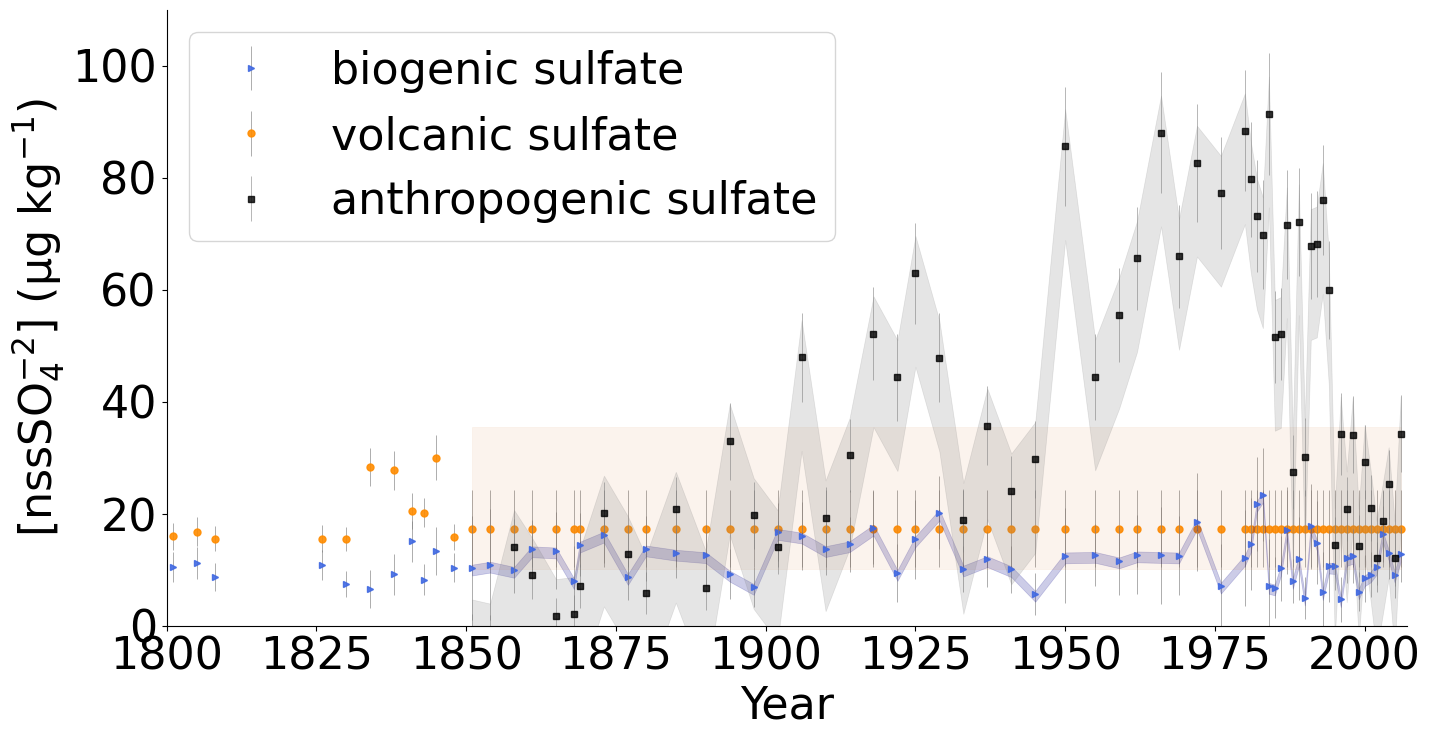

In [27]:
# bio=bioSO4_pre
# volc=volcSO4_pre
j=32
size = 5
fig, ax = plt.subplots(figsize = [16,8])
ax.set_ylabel('[nssSO$_4^{-2}$] (µg kg$^{-1}$)',fontsize=j)
ax.set_xlabel('Year',fontsize=j)
# plt.title('Volcanic, biogenic, anthropogenic non-sea salt sulfate (big eruptions excluded)',fontsize = 18)
ax.set_xlim([1800,2007])
ax.set_ylim([0,110])

ax.errorbar(bioSO4_pre.index,bioSO4_pre,sigma_bio_pre,fmt='>',markersize=size,color='royalblue',
             ecolor='gray',linewidth=0.5,label='biogenic sulfate',alpha=0.9,zorder=1)
ax.errorbar(bioSO4_ind.index,bioSO4_ind,sigma_bio_ind,fmt='>',markersize=size,color='royalblue',
             ecolor='gray',linewidth=0.5,alpha=0.9,zorder=1)

ax.errorbar(volcSO4_pre.index,volcSO4_pre,sigma_volc_pre,fmt='.',markersize=size*2,color='darkorange',
             ecolor='gray',linewidth=0.5,label='volcanic sulfate',alpha=0.9,zorder=0)
ax.errorbar(bioSO4_ind.index,volcSO4_ind,sigma_volc_ind,fmt='.',markersize=size*2,color='darkorange',
             ecolor='gray',linewidth=0.5,alpha=0.9,zorder=0)

plt.errorbar(bioSO4_ind.index,anthSO4,sigma_anthro,fmt='s',markersize=size,color='k',
             ecolor='gray',linewidth=0.5,label='anthropogenic sulfate',alpha=0.8,zorder=2)

ax.fill_between(bioSO4_ind.index,bioSO4_ind_2pt5,bioSO4_ind_97pt5,color='darkblue',linewidth=0.5,
                 alpha=0.2) #,label='biogenic sulfate')
ax.fill_between(bioSO4_ind.index,volcSO4_ind_2pt5,volcSO4_ind_97pt5,color='chocolate',linewidth=0.5,
                 alpha=0.08) #,label='volcanic sulfate')
ax.fill_between(bioSO4_ind.index,anthSO4_2pt5,anthSO4_97pt5,color='gray',linewidth=0.5,
                 alpha=0.2) #,label='anthropogenic sulfate')

ax.legend(loc='upper left',fontsize=j)
ax.tick_params(labelsize=j)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Text(-0.08, 0.95, 'b')

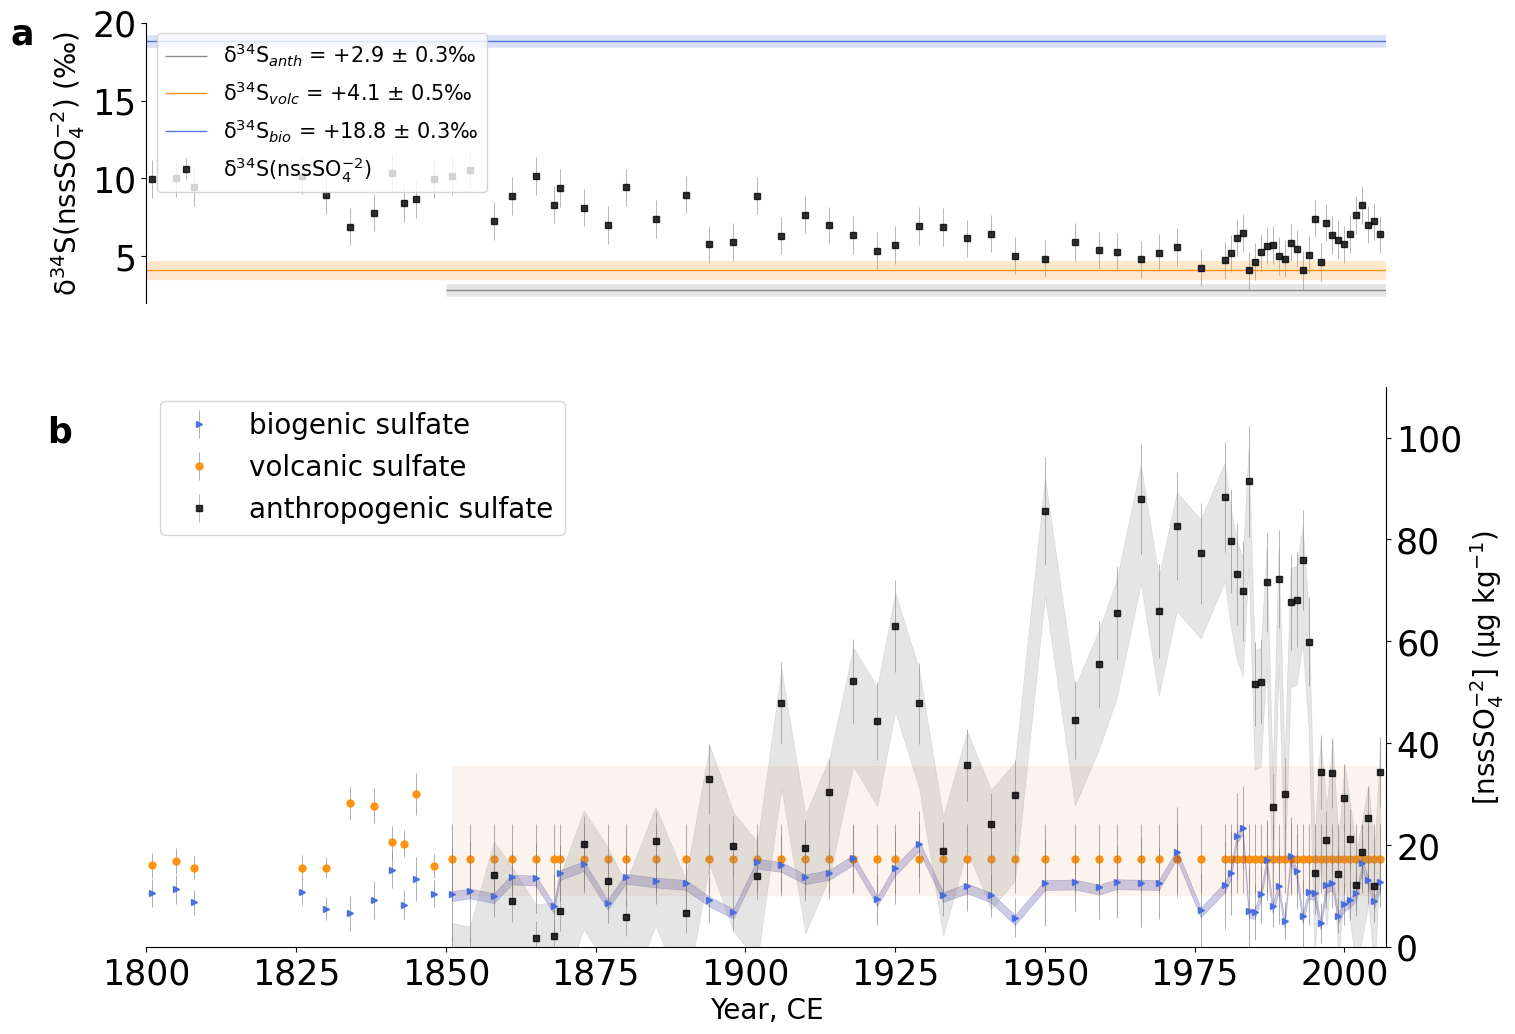

In [28]:
# bio=bioSO4_pre
# volc=volcSO4_pre
j=25
size = 5
fig, ax = plt.subplots(nrows=2,ncols=1,figsize = [16,12],gridspec_kw={'height_ratios': [1, 2]})
ax[0].set_ylabel('')
ax[0].set_ylabel('δ$^{34}$S(nssSO$_4^{-2}$) (‰)',fontsize=j-5)
ax[1].set_ylabel('[nssSO$_4^{-2}$] (µg kg$^{-1}$)',fontsize=j-5)
ax[1].set_xlabel('Year, CE',fontsize=j-5)
# plt.title('Volcanic, biogenic, anthropogenic non-sea salt sulfate (big eruptions excluded)',fontsize = 18)
ax[0].set_xlim([1800,2007])
ax[1].set_xlim([1800,2007])
ax[0].set_ylim([2,20])
ax[1].set_ylim([0,110])

ax[0].errorbar(d34S_pre.index,d34S_pre.values,process_std_std,fmt='s',color='k',ecolor='gray',markersize=size,linewidth=0.5,alpha=0.8,label='δ$^{34}$S(nssSO$_4^{-2}$)')
ax[0].errorbar(d34S_ind.index,d34S_ind.values,process_std_std,fmt='s',color='k',ecolor='gray',markersize=size,linewidth=0.5,alpha=0.8)
ax[0].hlines(2.8,1850,2010,linestyles = '-',color = 'gray',linewidth = 9,alpha=0.2)
ax[0].hlines(4.1,1200,2010,linestyles = '-',color = 'darkorange',linewidth = 14,alpha=0.2)
ax[0].hlines(18.8,1200,2010,linestyles = '-',color = 'royalblue',linewidth = 9,alpha=0.2)
ax[0].hlines(2.8,1850,2010,linestyles = '-',color = 'gray',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{anth}$ = +2.9 ± 0.3‰')
ax[0].hlines(4.1,1200,2010,linestyles = '-',color = 'darkorange',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{volc}$ = +4.1 ± 0.5‰')
ax[0].hlines(18.8,1200,2010,linestyles = '-',color = 'royalblue',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰')

# p1 = ax[0].errorbar(year_pre,d34S_pre.values,process_std_std,fmt='s',color='k',ecolor='gray',markersize=size,linewidth=0.5,alpha=0.8)
# # p2 = ax[0].errorbar(patris_yr[5:],patris02_pi_d34S,1,fmt='o',color='k',ecolor='gray',markersize=m,linewidth=1,alpha=0.8,label ='δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)')
# # p2 = ax[0].scatter(patris_yr[5:],patris02_pi_d34S,marker='o',color='white',edgecolor='k',s=m**2*2,alpha=1,label ='δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)')
# p3 = ax[0].hlines(18.8,1200,2010,linestyles = '-',color = 'royalblue',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰')
# p4 = ax[0].hlines(4.1,1200,2010,linestyles = '-',color = 'darkorange',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{volc}$ = +4.1 ± 0.5‰')
# p5 = ax[0].hlines(2.8,1850,2010,linestyles = '-',color = 'tab:red',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{anth}$ = +2.9 ± 0.3‰')
# l0 = ax[0].legend([p1,p3,p4,p5], ['δ$^{34}$S(nssSO$_4^{2-}$)', #'δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)',
#                            'δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰','δ$^{34}$S$_{volc}$ = +4.1 ± 0.5‰',
#                                      'δ$^{34}$S$_{anth}$ = +2.9 ± 0.3‰'],loc='upper right',fontsize=j-8)


ax[1].errorbar(bioSO4_pre.index,bioSO4_pre,sigma_bio_pre,fmt='>',markersize=size,color='royalblue',
             ecolor='gray',linewidth=0.5,label='biogenic sulfate',alpha=0.9,zorder=1)
ax[1].errorbar(bioSO4_ind.index,bioSO4_ind,sigma_bio_ind,fmt='>',markersize=size,color='royalblue',
             ecolor='gray',linewidth=0.5,alpha=0.9,zorder=1)

ax[1].errorbar(volcSO4_pre.index,volcSO4_pre,sigma_volc_pre,fmt='.',markersize=size*2,color='darkorange',
             ecolor='gray',linewidth=0.5,label='volcanic sulfate',alpha=0.9,zorder=0)
ax[1].errorbar(bioSO4_ind.index,volcSO4_ind,sigma_volc_ind,fmt='.',markersize=size*2,color='darkorange',
             ecolor='gray',linewidth=0.5,alpha=0.9,zorder=0)

ax[1].errorbar(bioSO4_ind.index,anthSO4,sigma_anthro,fmt='s',markersize=size,color='k',
             ecolor='gray',linewidth=0.5,label='anthropogenic sulfate',alpha=0.8,zorder=2)

ax[1].fill_between(bioSO4_ind.index,bioSO4_ind_2pt5,bioSO4_ind_97pt5,color='darkblue',linewidth=0.5,
                 alpha=0.2) #,label='biogenic sulfate')
ax[1].fill_between(bioSO4_ind.index,volcSO4_ind_2pt5,volcSO4_ind_97pt5,color='chocolate',linewidth=0.5,
                 alpha=0.08) #,label='volcanic sulfate')
ax[1].fill_between(bioSO4_ind.index,anthSO4_2pt5,anthSO4_97pt5,color='gray',linewidth=0.5,
                 alpha=0.2) #,label='anthropogenic sulfate')

ax[0].legend(loc='upper left',fontsize=j-10)
ax[1].legend(loc='upper left',fontsize=j-5)
ax[0].tick_params(labelsize=j)
ax[1].tick_params(labelsize=j)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.get_xaxis().set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[0].text(-0.11, 1.02, 'a', transform=ax[0].transAxes,fontsize=j, fontweight='bold', va='top')
ax[1].text(-0.08, 0.95, 'b', transform=ax[1].transAxes,fontsize=j, fontweight='bold', va='top')



In [29]:
all_data = pd.read_excel('./Data/all_data.xlsx').drop(8711).drop(8710)
year1 = all_data.year1
SO4_raw = all_data.SO4
nssSO4_raw = all_data.nssSO4
year = year1.values[::-1]
tstep=1
yr=np.linspace(int(year[1]),1202,int((2007-1202)/tstep+1))
nssSO4_df = pd.DataFrame(data=nssSO4_raw.values,index=year1.values,columns=['nssSO4'])
# nssSO4_1yr = nssSO4_df.groupby('year').mean()
nssSO4_1yr = nssSO4_df.groupby(by=None, axis=0, level=0, as_index=True).mean()

## Emissions Data
From the Community Emissions Data System (CEDS)

In [31]:
anthroSO2 = xr.open_dataset('./Data/SO2-em-anthro_CMIP_CEDS_1850-2019.nc')
SO2_agr = anthroSO2.SO2_agr
SO2_ene = anthroSO2.SO2_ene
SO2_ind = anthroSO2.SO2_ind
SO2_rco = anthroSO2.SO2_rco
SO2_shp = anthroSO2.SO2_shp
SO2_slv = anthroSO2.SO2_slv
SO2_tra = anthroSO2.SO2_tra
SO2_wst = anthroSO2.SO2_wst
anthroSO2_all_1850_2019 = SO2_agr + SO2_ene + SO2_ind + SO2_rco + SO2_shp + SO2_slv +SO2_tra + SO2_wst

In [32]:
# CREATE 1x1 DEGREE AREA FIELD

deg_to_rad = np.pi / 180
lat_difs = np.abs(np.sin(anthroSO2.isel(lat=slice(0,359)).lat.values*deg_to_rad)
                  - np.sin(anthroSO2.isel(lat=slice(1,360)).lat.values*deg_to_rad))
lon_difs = np.abs(anthroSO2.isel(lon=slice(0,719)).lon.values - anthroSO2.isel(lon=slice(1,720)).lon.values)*deg_to_rad

lat_grid = np.zeros([len(lat_difs),len(lon_difs)])
lon_grid = np.zeros([len(lat_difs),len(lon_difs)])

for i in range(0,len(lon_difs)):
    lat_grid[:,i] = lat_difs
    
for i in range(0,len(lat_difs)):
    lon_grid[i,:] = lon_difs
    
ceds_grid = np.zeros([len(lat_difs),len(lon_difs)])

for i in range(0,len(lat_difs)):
    for j in range(0,len(lon_difs)):

        ceds_grid[i,j] = lat_difs[i]*lon_difs[j]
        
R = 6378100 #radius of Earth in meters
area_ceds_reduced = R**2 * ceds_grid 

area_ceds = np.zeros([360,720])
area_ceds[0,:] = area_ceds_reduced[0,0]
area_ceds[:,0] = area_ceds_reduced[0,0]

area_ceds[359,:] = area_ceds_reduced[358,718]
area_ceds[:,718] = area_ceds_reduced[358,718]

area_ceds[1:360,1:720] = area_ceds_reduced

# I HAVE CHECKED AND THE AREA OF THE EARTH IS 510 TRILLION M2, WHICH ALIGNS WITH AREA_CEDS

In [33]:
sec_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31]) * 86400
sec_in_month_1850_2019 = np.array([])

for i in range(0,(2019-1850)+2):
    sec_in_month_1850_2019 = np.hstack([sec_in_month_1850_2019,sec_in_month])

anthroSO2_emiss_1850_2019 = np.zeros([len(sec_in_month_1850_2019),len(anthroSO2_all_1850_2019.lat),
                                    len(anthroSO2_all_1850_2019.lon)])
for i in range(0,len(sec_in_month_1850_2019),1): 
    anthroSO2_emiss_1850_2019[i,:,:] = (
        anthroSO2_all_1850_2019[i,:,:]) * sec_in_month_1850_2019[i] * area_ceds

1850-01-01T00:00:00.000000000


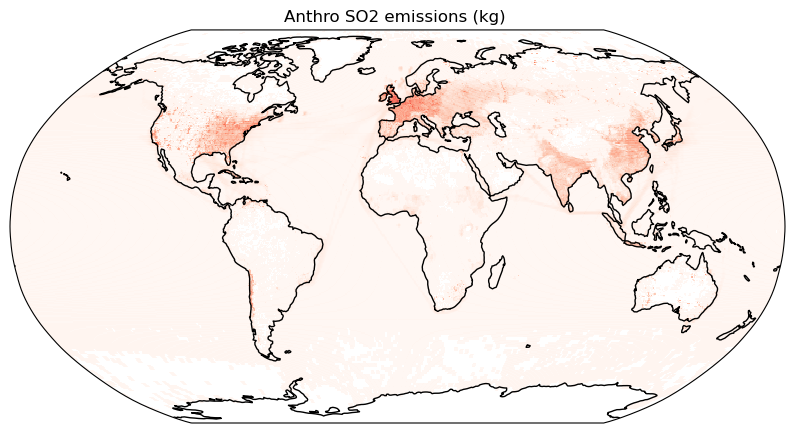

In [34]:
fig = plt.figure(figsize=[10,8])
ax = plt.subplot(projection=ccrs.Robinson())
a=10
color_norm = mpl.colors.LogNorm(1e2,1e9)
t=0
ax.pcolormesh(anthroSO2.lon,anthroSO2.lat,anthroSO2_emiss_1850_2019[t,:,:],cmap='Reds',norm=color_norm,transform=ccrs.PlateCarree(),alpha=0.8)
ax.set_title('Anthro SO2 emissions (kg) ')
ax.coastlines()
dm_nit = plt.cm.ScalarMappable(cmap='Reds',norm=color_norm)
dm_nit.set_array([])
# cbar = plt.colorbar(dm_nit, orientation = 'horizontal',pad=0.02)
# cbar.set_label('Emissions (kg SO2)', rotation=0,labelpad=10,fontsize=12)
print(anthroSO2.isel(time=t).time.values)

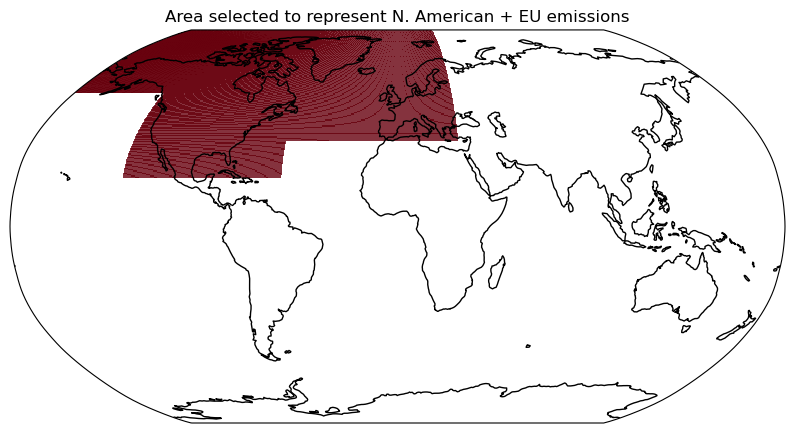

In [35]:
eunasu_cells = np.zeros(np.shape(area_ceds))
eunasu_cells[250:,250:420]=1 #EU
eunasu_cells[220:,100:250]=1 # N. America
eunasu_cells[290:,0:150]=1 # Alaska
# eunasu_cells[220:,550:720]=1 # Asia

na_cells = np.zeros(np.shape(area_ceds))
na_cells[220:,100:250]=1 # N. America
na_cells[290:,0:150]=1 # Alaska

eu_cells = np.zeros(np.shape(area_ceds))
eu_cells[250:,250:420]=1 # N. America


fig = plt.figure(figsize=[10,8])
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
a=10
color_norm = mpl.colors.LogNorm(1e-10,1)

ax.pcolormesh(anthroSO2.lon,anthroSO2.lat,eunasu_cells,cmap='Reds',norm=color_norm,transform=ccrs.PlateCarree(),alpha=0.8)
ax.set_title('Area selected to represent N. American + EU emissions')
ax.coastlines()

In [36]:
ceds_eunasu_emiss = np.zeros(np.shape(anthroSO2_emiss_1850_2019))
ceds_na_emiss = np.zeros(np.shape(anthroSO2_emiss_1850_2019))
ceds_eu_emiss = np.zeros(np.shape(anthroSO2_emiss_1850_2019))

for i in range(0,np.shape(anthroSO2_emiss_1850_2019)[0]):
    ceds_eunasu_emiss[i,:,:] = anthroSO2_emiss_1850_2019[i,:,:]*eunasu_cells
    ceds_na_emiss[i,:,:] = anthroSO2_emiss_1850_2019[i,:,:]*na_cells
    ceds_eu_emiss[i,:,:] = anthroSO2_emiss_1850_2019[i,:,:]*eu_cells

In [37]:
ceds_yrs = np.linspace(1850,2019,(2019-1850)+1)
eunasuSO2_annual = np.zeros([len(ceds_yrs),360,720])
global_annual_ceds = np.zeros([len(ceds_yrs),360,720])
naSO2_annual = np.zeros([len(ceds_yrs),360,720])
euSO2_annual = np.zeros([len(ceds_yrs),360,720])

eunasuSO2_1750 = np.zeros([360,720])
global_1750_ceds = np.zeros([360,720])
naSO2_1750 = np.zeros([360,720])

for i in range(0,len(ceds_yrs)):
#     print(ceds_yrs[i])
    for j in range(0,12):
        eunasuSO2_annual[i,:,:] = eunasuSO2_annual[i,:,:] + ceds_eunasu_emiss[(i*12 + j),:,:]
        naSO2_annual[i,:,:] = naSO2_annual[i,:,:] + ceds_na_emiss[(i*12 + j),:,:]
        euSO2_annual[i,:,:] = euSO2_annual[i,:,:] + ceds_eu_emiss[(i*12 + j),:,:]
        global_annual_ceds[i,:,:] = global_annual_ceds[i,:,:] + anthroSO2_emiss_1850_2019[(i*12 + j),:,:]

In [38]:
na_eu_su_emiss_ceds = eunasuSO2_annual.sum(axis=1).sum(axis=1)
na_emiss_ceds = naSO2_annual.sum(axis=1).sum(axis=1)
eu_emiss_ceds = euSO2_annual.sum(axis=1).sum(axis=1)
global_emiss_ceds   = global_annual_ceds.sum(axis=1).sum(axis=1)

In [39]:
# Get emissions from excel file with Smith et al. 2011 numbers

na_eu_su_emiss_smith = mainfig['Total NA, EU, FS emissions (Gg/yr)'][0:156] * 1e6
na_emiss_smith = mainfig['North America emissions (Gg/yr)'][0:156] * 1e6
eu_emiss_smith = mainfig['Europe emissions (Gg/yr)'][0:156] * 1e6
year_smith = mainfig.year[0:156]

differences could be related to region selection


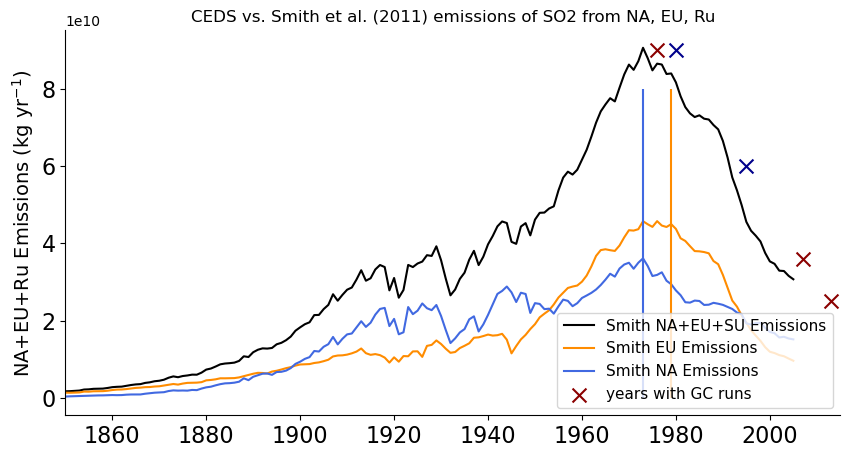

In [40]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=[10,5])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.1)
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0)

l = 1.5
el = 0.5
aa = 0.8
aaa=0.05
j=16
size=100
# ax.scatter(2013,x2,marker='s',s=size,
#                color='maroon',label='2013 estimate from GEOS-Chem',alpha=aa)
ax.plot(year_smith,na_eu_su_emiss_smith,linestyle='-',color='k',linewidth=l,
         label='Smith NA+EU+SU Emissions')
ax.plot(year_smith,eu_emiss_smith,linestyle='-',color='darkorange',linewidth=l,
         label='Smith EU Emissions')
ax.plot(year_smith,na_emiss_smith,linestyle='-',color='royalblue',linewidth=l,
         label='Smith NA Emissions')
ax.set_xlim([1850,2015])

ax.vlines(1973,0,8e10,color='royalblue')
ax.vlines(1979,0,8e10,color='darkorange')

ax.scatter(1976,9e10,marker='x',color='darkred',s=size)
ax.scatter(1980,9e10,marker='x',color='darkblue',s=size)
ax.scatter(1995,6e10,marker='x',color='darkblue',s=size)
ax.scatter(2007,3.6e10,marker='x',color='darkred',s=size)
ax.scatter(2013,2.5e10,marker='x',color='darkred',s=size,label='years with GC runs')
# ax.set_ylim([0,1])

ax.set_ylabel('NA+EU+Ru Emissions (kg yr$^{-1}$)',fontsize=j-2)

ax.tick_params(axis='x', labelsize= j)
ax.tick_params(axis='y', labelsize= j)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', fontsize= j-5)
ax.set_title('CEDS vs. Smith et al. (2011) emissions of SO2 from NA, EU, Ru')
print('differences could be related to region selection')

In [41]:
all_data = pd.read_excel('./Data/all_data.xlsx').drop(8711).drop(8710)
year1 = all_data.year1
SO4_raw = all_data.SO4
nssSO4_raw = all_data.nssSO4
year = year1.values[::-1]
tstep=1
yr=np.linspace(int(year[1]),1202,int((2007-1202)/tstep+1))
nssSO4_df = pd.DataFrame(data=nssSO4_raw.values,index=year1.values,columns=['nssSO4'])
# nssSO4_1yr = nssSO4_df.groupby('year').mean()
nssSO4_1yr = nssSO4_df.groupby(by=None, axis=0, level=0, as_index=True).mean()

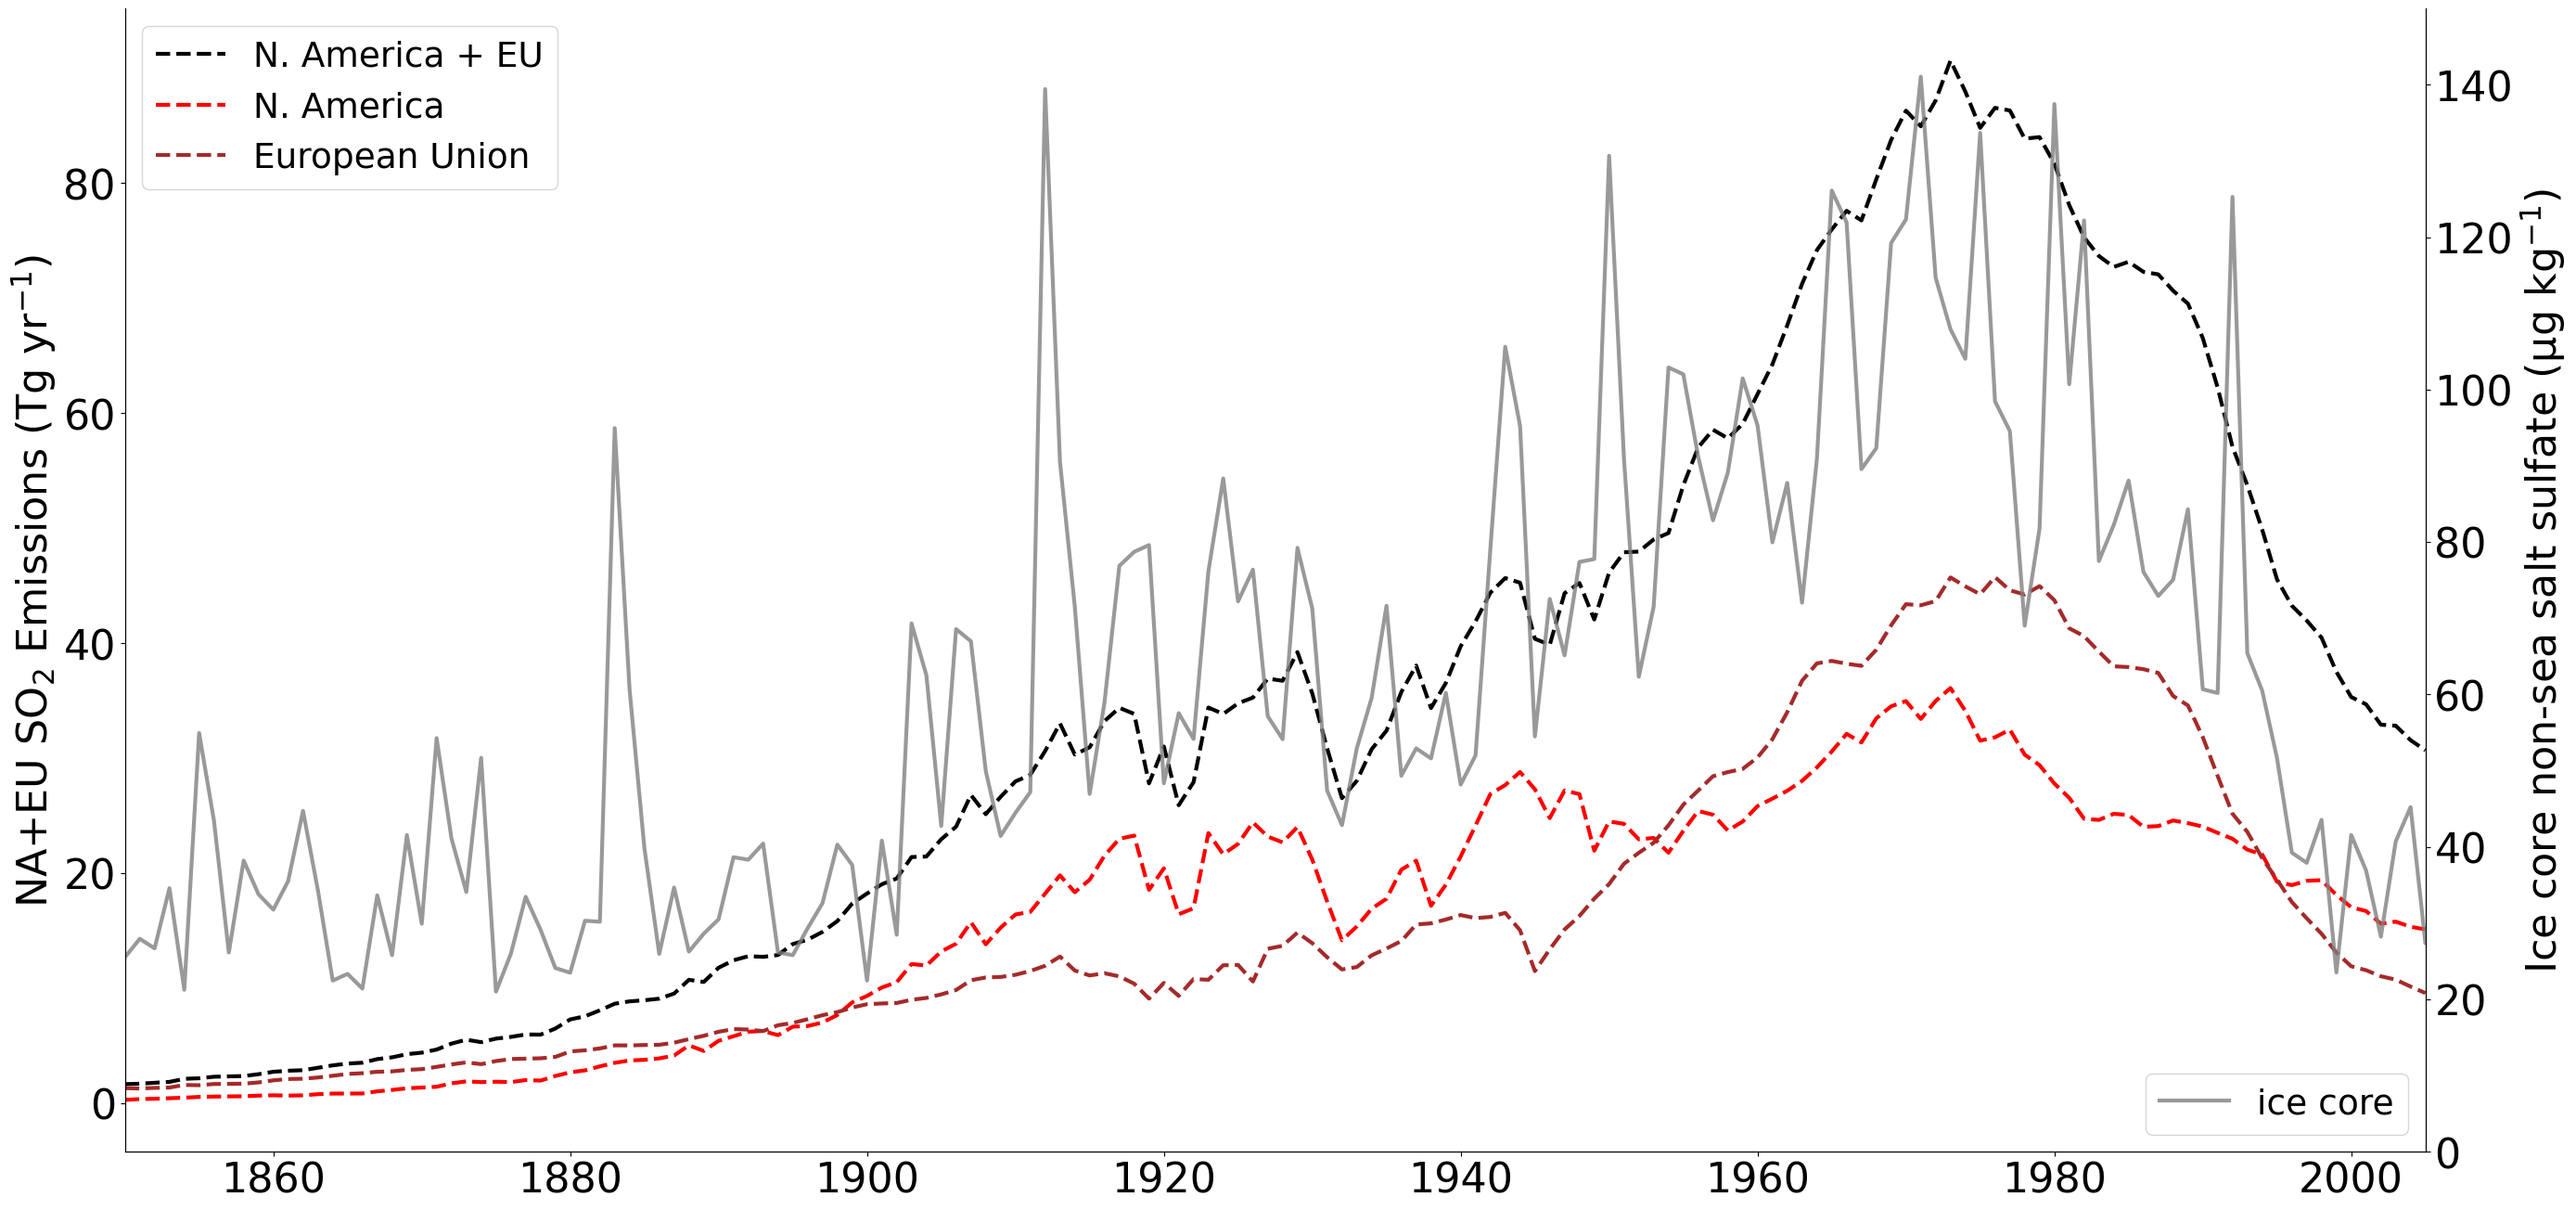

In [42]:
na_emiss_Ggyr = mainfig['North America emissions (Gg/yr)']
eu_emiss_Ggyr = mainfig['Europe emissions (Gg/yr)']
su_emiss_Ggyr = mainfig['Former S emissions (Gg/yr)']
t_emiss_Ggyr = na_emiss_Ggyr + eu_emiss_Ggyr + su_emiss_Ggyr
yr = mainfig['year']
ice_core_nssSO4 = mainfig['ice core SO42- [mg/L]']


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=[32,16])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.1)
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0)

l = 3
el = 0.5
aa = 0.8
aaa=0.05
j=32
size=100

ax.plot(yr,t_emiss_Ggyr/1e3,linestyle='--',color='k',linewidth=l,
         label='N. America + EU')
ax.plot(yr,na_emiss_Ggyr/1e3,linestyle='--',color='r',linewidth=l,
         label='N. America')
ax.plot(yr,eu_emiss_Ggyr/1e3,linestyle='--',color='brown',linewidth=l,
         label='European Union')
# ax.plot(yr,su_emiss_Ggyr/1e3,linestyle='--',color='darkblue',linewidth=l,
#          label='Former Soviet Union')
ax.set_xlim([1850,2005])

ax.set_ylabel('NA+EU SO$_2$ Emissions (Tg yr$^{-1}$)',fontsize=j)

ax.tick_params(axis='x', labelsize= j)
ax.tick_params(axis='y', labelsize= j)

ax2 = ax.twinx()
ax2.plot(nssSO4_1yr.index,nssSO4_1yr,linewidth=l,color='gray',alpha=aa,label='ice core')


ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_ylim([0,150])
ax.legend(loc='upper left', fontsize= j-5)

ax2.tick_params(axis='x', labelsize= j)
ax2.tick_params(axis='y', labelsize= j)

ax2.set_ylabel('Ice core non-sea salt sulfate (µg kg$^{-1}$)',fontsize=j)
ax2.legend(loc='lower right', fontsize= j-5)

# ax.set_title('CEDS vs. Smith et al. (2011) emissions of SO2 from NA, EU, Ru')
# print('differences could be related to region selection')
# fig.savefig('./summary.png')

In [43]:
patris02_pi = patris_data.loc[patris_data.MeanDate<1850]
patris02_pi_nssSO4 = patris02_pi.PatrisnssSO4
patris02_pi_d34S = patris02_pi.d34SnssSO4
patris02_pd = patris_data.loc[patris_data.MeanDate>1850]
patris02_pd_nssSO4 = patris02_pd.PatrisnssSO4
patris02_pd_d34S = patris02_pd.d34SnssSO4
patris_yr = patris_data.MeanDate
patris_d34S_tot = patris_data.d34S_tot
patris_d34S_nssSO4_orig = patris_data.d34SnssSO4
iaeas1_d34Sacc = -0.3
iaeas2_d34Sacc = 22.62
iaeas3_d34Sacc = -32.49
iaeas4_d34Sacc = 16.90
iaeas5_d34Sacc = 0.49
iaeas6_d34Sacc = -34.05
nbs127_d34Sacc = 21.12
# correct Patris data because IAEA-S-2 used to be 21.8 but was corrected to 22.62 after Patris paper was published
patris_VCDT_corr_func = np.polyfit([iaeas1_d34Sacc,21.8,nbs127_d34Sacc],
                                   [iaeas1_d34Sacc,iaeas2_d34Sacc,nbs127_d34Sacc],1)
patris_wSSA_d34S_CORR = patris_VCDT_corr_func[0]*patris_d34S_tot+patris_VCDT_corr_func[1]

d34Sss = 21 # d34S of sea salt
patris_fss = 0.25*(patris_data.Na)/(patris_data.SO4) # calculate the fraction of sea salt in each ice core sample
patris_d34S_CORR = (patris_wSSA_d34S_CORR-d34Sss*patris_fss)/(1-patris_fss)

patris02_pi_d34S_CORR = patris_d34S_CORR[patris_data.MeanDate<1850]
patris02_pd_d34S_CORR = patris_d34S_CORR[patris_data.MeanDate>1850]

patris02_pi_nssSO4 = patris_data.loc[patris_data.MeanDate<1850].PatrisnssSO4
patris02_pd_nssSO4 = patris_data.loc[patris_data.MeanDate>1850].PatrisnssSO4


# Our Ice Core Data

Here I'm loading in the supplementary datasets. These files were created using the analysis above.

In [45]:
ice_core_pi = pd.read_excel('./Data/Supplementary_data_1_ice_core_measurements_pi.xlsx')
ice_core_pd = pd.read_excel('./Data/Supplementary_data_1_ice_core_measurements_pd.xlsx')

year_pre        = ice_core_pi['Year']
year_ind        = ice_core_pd['Year']

# Figure 2 from Jongebloed et al. (2023) ERL

Text(-0.06, 0.95, 'b')

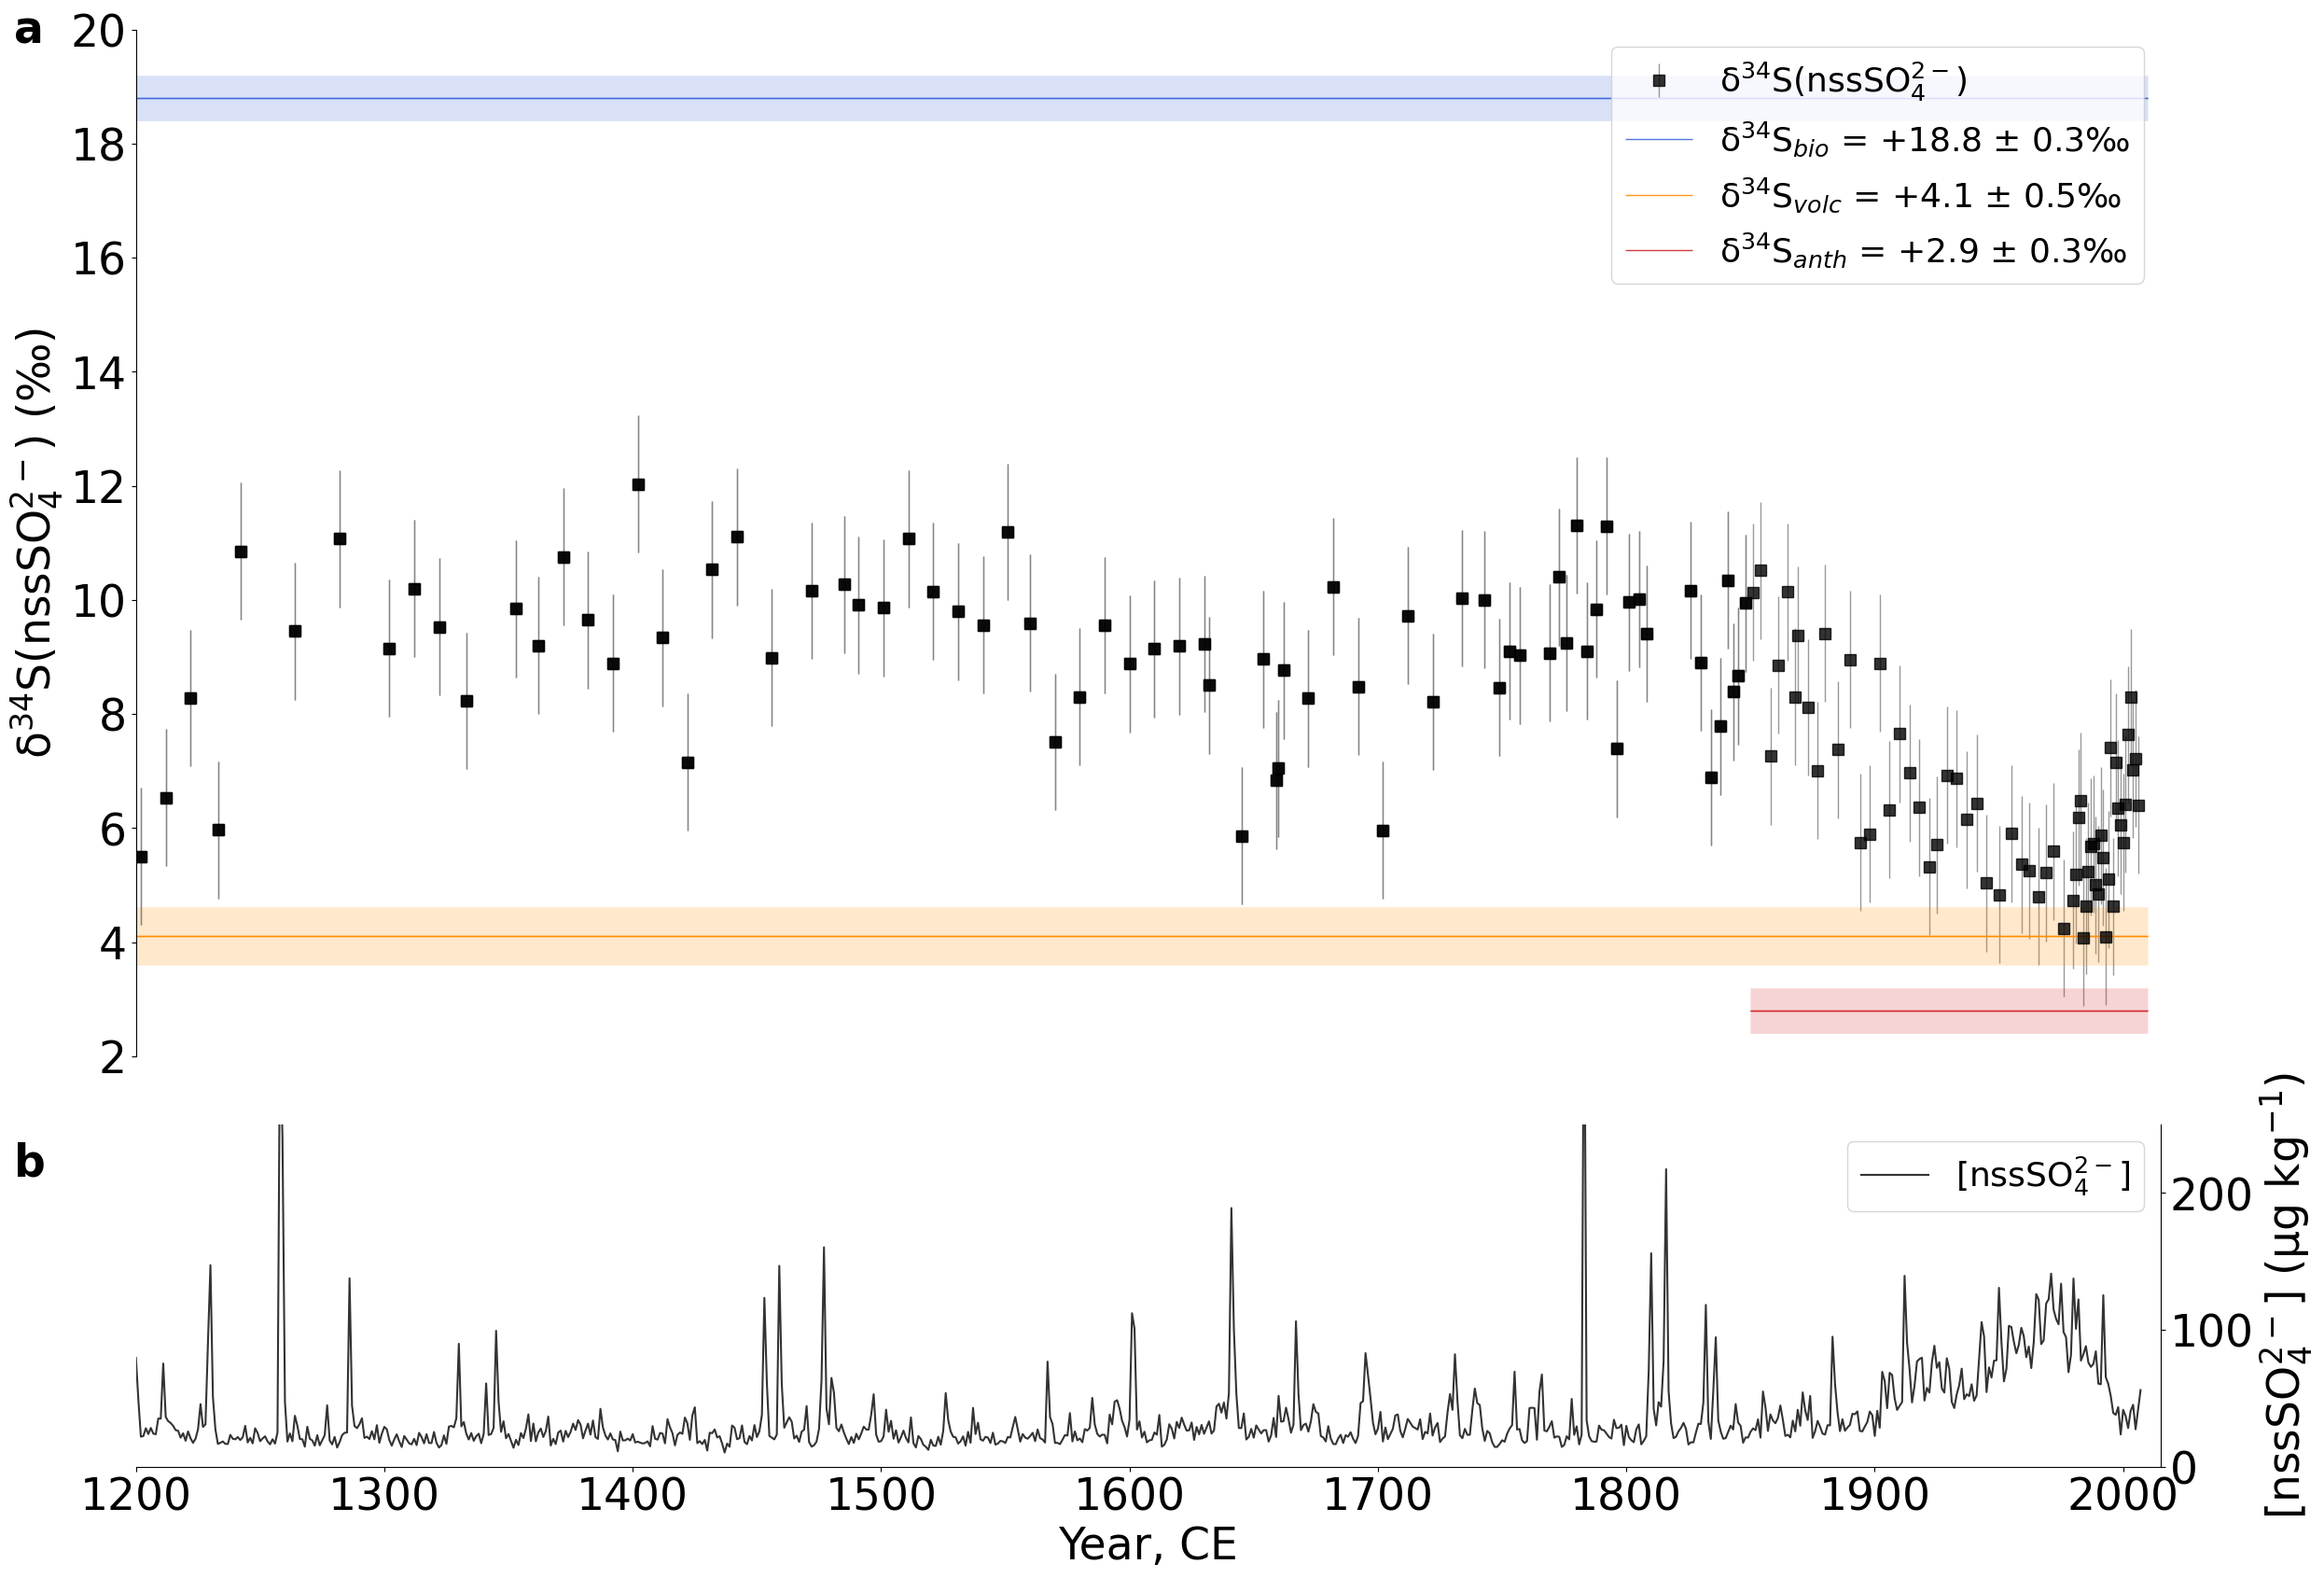

In [49]:
year_pre=bioSO4_pre.index
year_ind = bioSO4_ind.index

fig, ax = plt.subplots(ncols=1,nrows=2,figsize=[28,20],gridspec_kw={'height_ratios': [3, 1]},dpi=100) # switch dpi to 600 for higher quality figure
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
j=34

for i in range(0,2,1):
    ax[i].patch.set_facecolor('white')
    ax[i].patch.set_alpha(0)

size = 12
s = 200
line=2
meanline=3
m=8
ax[0].errorbar(year_pre,d34S_pre.values,process_std_std,fmt='s',color='k',ecolor='gray',markersize=m,linewidth=1,alpha=0.8)
ax[0].errorbar(year_ind,d34S_ind.values,process_std_std,fmt='s',color='k',ecolor='gray',markersize=m,linewidth=1,alpha=0.8)
# ax[0].scatter(patris_yr[5:],patris02_pi_d34S,marker='o',color='white',edgecolor='k',s=m**2*2,alpha=1,label ='δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)')
# ax[0].errorbar(patris_yr[5:],patris02_pi_d34S,1,fmt='o',color='white',ecolor='gray',markersize=m,linewidth=1,alpha=0.8)
# ax[0].scatter(patris_yr[:5],patris02_pd_d34S,marker='o',color='white',edgecolor='k',s=m**2*2,alpha=1)
# ax[0].errorbar(patris_yr[:5],patris02_pd_d34S,1,fmt='o',color='white',ecolor='gray',markersize=m,linewidth=1,alpha=0.8)
ax[0].hlines(2.8,1850,2010,linestyles = '-',color = 'tab:red',linewidth = 35,alpha=0.2)
ax[0].hlines(4.1,1200,2010,linestyles = '-',color = 'darkorange',linewidth = 45,alpha=0.2)
ax[0].hlines(18.8,1200,2010,linestyles = '-',color = 'royalblue',linewidth = 35,alpha=0.2)
ax[0].hlines(2.8,1850,2010,linestyles = '-',color = 'tab:red',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{anth}$ = +2.9 ± 0.3‰')
ax[0].hlines(4.1,1200,2010,linestyles = '-',color = 'darkorange',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{volc}$ = +4.1 ± 0.5‰')
ax[0].hlines(18.8,1200,2010,linestyles = '-',color = 'royalblue',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰')

p1 = ax[0].errorbar(year_pre,d34S_pre.values,process_std_std,fmt='s',color='k',ecolor='gray',markersize=m,linewidth=1,alpha=0.8)
# p2 = ax[0].errorbar(patris_yr[5:],patris02_pi_d34S,1,fmt='o',color='k',ecolor='gray',markersize=m,linewidth=1,alpha=0.8,label ='δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)')
# p2 = ax[0].scatter(patris_yr[5:],patris02_pi_d34S,marker='o',color='white',edgecolor='k',s=m**2*2,alpha=1,label ='δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)')
p3 = ax[0].hlines(18.8,1200,2010,linestyles = '-',color = 'royalblue',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰')
p4 = ax[0].hlines(4.1,1200,2010,linestyles = '-',color = 'darkorange',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{volc}$ = +4.1 ± 0.5‰')
p5 = ax[0].hlines(2.8,1850,2010,linestyles = '-',color = 'tab:red',linewidth = 1,alpha=0.9,label='δ$^{34}$S$_{anth}$ = +2.9 ± 0.3‰')
l0 = ax[0].legend([p1,p3,p4,p5], ['δ$^{34}$S(nssSO$_4^{2-}$)', #'δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)',
                           'δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰','δ$^{34}$S$_{volc}$ = +4.1 ± 0.5‰',
                                     'δ$^{34}$S$_{anth}$ = +2.9 ± 0.3‰'],loc='upper right',fontsize=j-8)
# l1 = ax[0].legend([p1,p2], ['δ$^{34}$S(nssSO$_4^{2-}$) (this study)','δ$^{34}$S(nssSO$_4^{2-}$) (Patris et al., 2002)',],loc='upper right',fontsize=j-8)

# ax[0].text(1200,4.5,"δ$^{34}$S$_{volc}$ = +4.3 ± 0.5‰", fontsize=j-6,alpha=1)
# ax[0].text(1200,18.9,"δ$^{34}$S$_{bio}$ = +18.8 ± 0.3‰", fontsize=j-6,alpha=1)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].axes.get_xaxis().set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[1].plot(nssSO4_1yr.index,nssSO4_1yr.values,color='k',linewidth=1.5,alpha=0.8,label='[nssSO$_4^{2-}$]')


ax[1].legend(loc='upper right',fontsize=j-8)

ax[0].tick_params(labelsize= j-2)
ax[1].tick_params(labelsize= j-2)

ax[0].set_ylabel('δ$^{34}$S(nssSO$_4^{2-}$) (‰)',fontsize=j)
ax[1].set_ylabel('[nssSO$_4^{2-}$] (µg kg$^{-1}$)',fontsize=j)
ax[1].set_xlabel('Year, CE',fontsize=j)
ax[0].set_xlim([1200,2015])
ax[1].set_xlim([1200,2015])
ax[0].set_ylim([2,20])
ax[1].set_ylim([0,250])

for i, label in enumerate(('A', 'B')):
    ax[i].tick_params(labelsize=j)

ax[0].text(-0.06, 1.02, 'a', transform=ax[0].transAxes,fontsize=j, fontweight='bold', va='top')
ax[1].text(-0.06, 0.95, 'b', transform=ax[1].transAxes,fontsize=j, fontweight='bold', va='top')

# fig.savefig('./Fig2.pdf ')

In [50]:
eruptions = pd.read_excel('./Data/IcelandAlaskaErupt.xlsx')[0:545]
iceland_alaska_erupt = eruptions.Year[eruptions['MaxVEI'].values>3]
yr1 = iceland_alaska_erupt.values[::-1]
yr2 = year_ind
yr3 = np.array([])
concs = np.array([])
# deps = np.array([])
fanths = np.array([])
i = 0
j = 0
while i < len(yr1) and j < len(yr2):
    if yr1[i] > yr2[j]:
        j = j+1
    elif yr1[i] < yr2[j]:
        i = i+1
    elif yr1[i] == yr2[j]:
        yr3 = np.hstack([yr3,yr1[i]])
        concs = np.hstack([concs,anthSO4.values[j]])
#         deps = np.hstack([deps,anthSO4_dep_mg_m2.values[j]])
        fanths = np.hstack([fanths,fanth.values[j]])
        i = i+1
        j = j+1
    elif yr1[i]+1 == yr2[j]:
        yr3 = np.hstack([yr3,yr1[i]+1])
        concs = np.hstack([concs,anthSO4.values[j]])
#         deps = np.hstack([deps,anthSO4_dep_mg_m2.values[j]])
        fanths = np.hstack([fanths,fanth.values[j]])
    else:
        print('error')
yr3

array([1976., 1980., 1981., 1986., 1992.])

In [51]:
eruptions_global = pd.read_excel('./Data/GlobalEruptions.xlsx')[0:2993]
big_erupt = eruptions_global.Year[eruptions_global['VEI'].values>4]
yr1 = big_erupt.values[::-1]
yr2 = year_ind
yr4 = np.array([])
concs2 = np.array([])
# deps2 = np.array([])
fanths2 = np.array([])
i = 0
j = 0
while i < len(yr1) and j < len(yr2):
    if yr1[i] > yr2[j]:
        j = j+1
    elif yr1[i] < yr2[j]:
        i = i+1
    elif yr1[i] == yr2[j]:
        yr4 = np.hstack([yr4,yr1[i]])
        concs2 = np.hstack([concs2,anthSO4.values[j]])
#         deps2 = np.hstack([deps2,anthSO4_dep_mg_m2.values[j]])
        fanths2 = np.hstack([fanths2,fanth.values[j]])
        i = i+1
        j = j+1
#     elif yr1[i]+1 == yr2[j]:
#         yr4 = np.hstack([yr4,yr1[i]+1])
#         concs2 = np.hstack([concs,anthSO4.values[j]])
    else:
        print('error')
yr4

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1991.])

In [52]:
# 1980, 1981, 1982, 1983, 1984, 1985, 1986 = St. Helens, VEI 5
# 1982 = El Chichon, VEI 5 and St Helens, VEI 5
eruptyrs = np.hstack([yr3[0],yr3[4],yr4[0],yr4[1],yr4[6],yr4[7]])
eruptconc = np.hstack([concs[0],concs[4],concs2[0],concs2[1],concs2[6],concs2[7]])
# eruptdep = np.hstack([deps[0],deps[4],deps2[0],deps2[1],deps2[6],deps2[7]])
eruptfrac = np.hstack([fanths[0],fanths[4],fanths2[0],fanths2[1],fanths2[6],fanths2[7]])

### Conclusions from volcanic eruption analysis
I should mark out St Helens (1980), El Chichon (1982), Pinatubo (1991), Augustine (1976 and 1986), and Spurr (1992)

# Figure 3 from Jongebloed et al. (2023) ERL

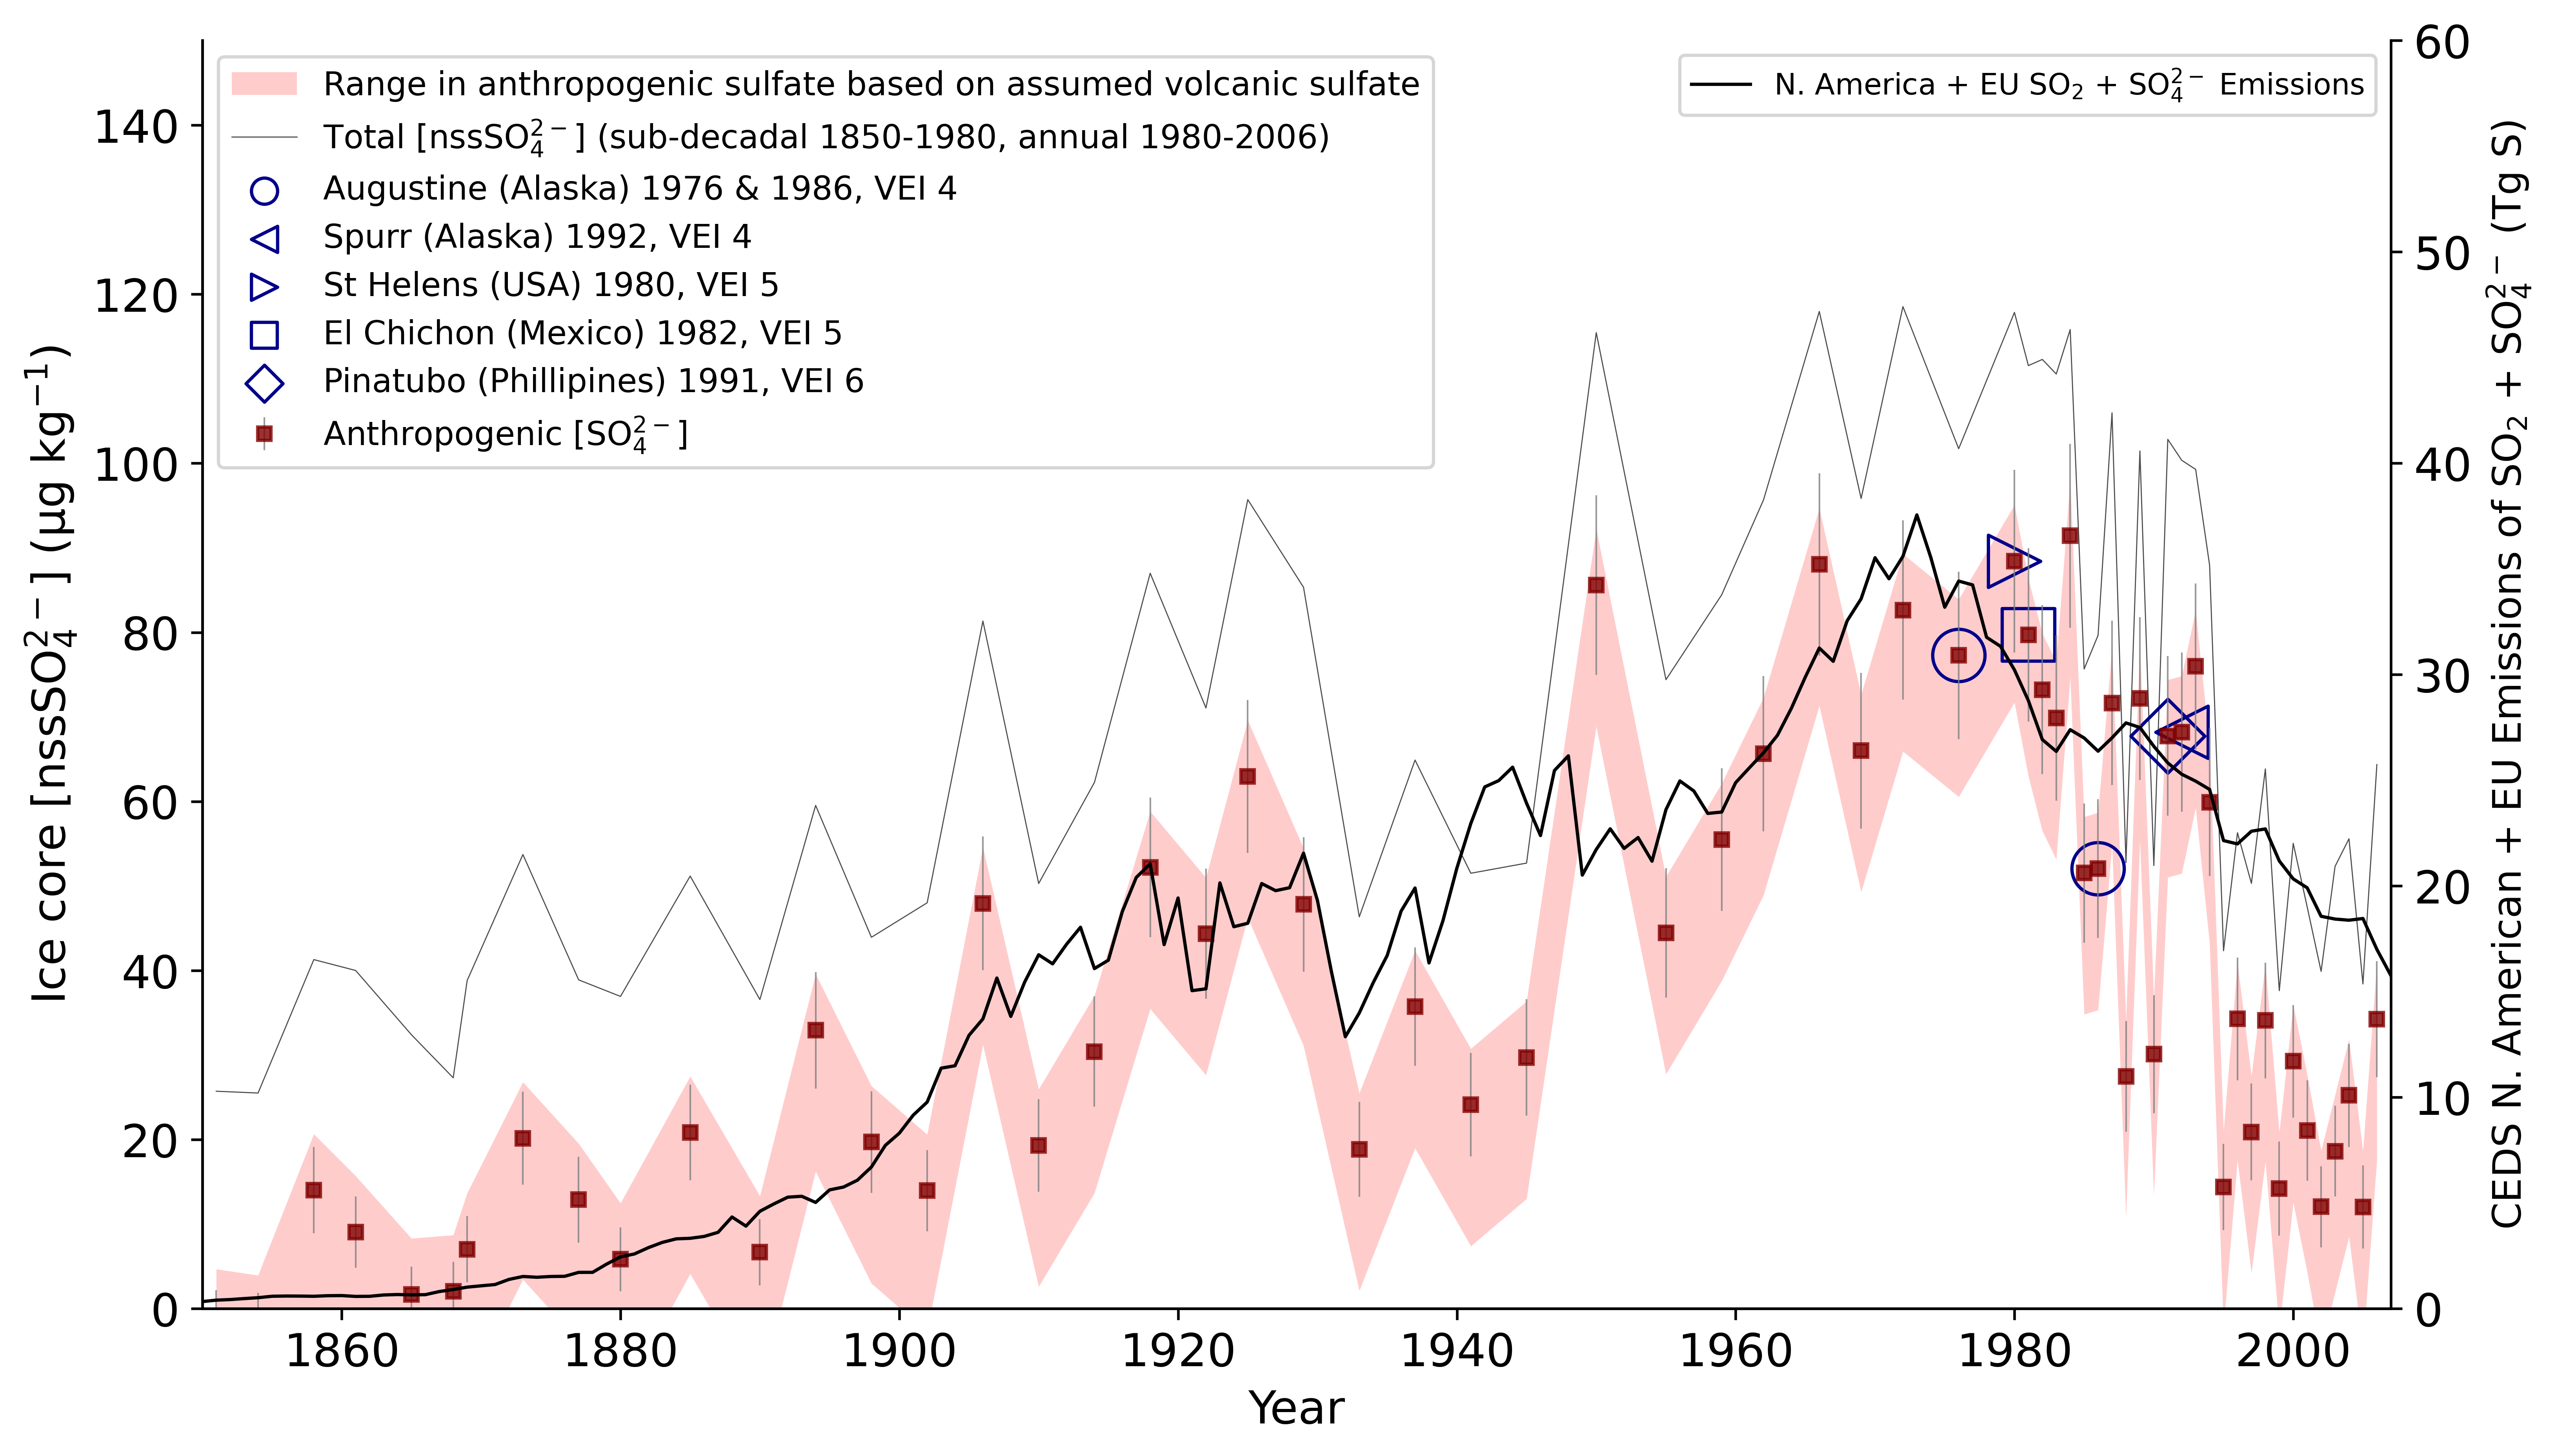

In [53]:
fig, ax = plt.subplots(figsize = [12,7],dpi = 600)
j=14
ax.set_ylabel('Ice core [nssSO$_4^{2-}$] (µg kg$^{-1}$)',fontsize=j)
ax.set_xlabel('Year',fontsize=j)
# plt.title('Volcanic, biogenic, anthropogenic non-sea salt sulfate (big eruptions excluded)',fontsize = 18)
ax.set_xlim([1850,2007])
ax.set_ylim([0,150])
t_emiss_Ggyr = (na_emiss_Ggyr + eu_emiss_Ggyr)*1e-3
yr = range(1850,2008,1)
size = 4
l=1
ax.errorbar(year_ind,anthSO4,sigma_anthro,fmt='s',markersize=size,zorder=2,
            color='maroon',ecolor='gray',linewidth=0.5,label='Anthropogenic [SO$_4^{2-}$]',alpha=0.8)
ax.fill_between(year_ind,anthSO4_97pt5,
                anthSO4_2pt5,color='red',linewidth=0,alpha=0.2,
                label='Range in anthropogenic sulfate based on assumed volcanic sulfate')
ax.scatter(eruptyrs[0],eruptconc[0],marker='o',s=size**4,color='#FF000000',edgecolor='darkblue')
#            label='Augustine (Alaska) 1976 & 1986, VEI 4')
ax.scatter(eruptyrs[1],eruptconc[1],marker='<',s=size**4,color='#FF000000',edgecolor='darkblue')
           #label='Spurr (Alaska) 1992, VEI 4')
ax.scatter(eruptyrs[2],eruptconc[2],marker='>',s=size**4,color='#FF000000',edgecolor='darkblue')
           #label='St Helens (USA) 1980, VEI 5')
ax.scatter(eruptyrs[3],eruptconc[3],marker='s',s=size**4,color='#FF000000',edgecolor='darkblue')
           #label='El Chichon (Mexico) 1982, VEI 5')
ax.scatter(eruptyrs[4],eruptconc[4],marker='o',s=size**4,color='#FF000000',edgecolor='darkblue')
ax.scatter(eruptyrs[5],eruptconc[5],marker='D',s=size**4,color='#FF000000',edgecolor='darkblue')
           #label='Pinatubo (Phillipines) 1991, VEI 6')
ax.plot(year_ind,nssSO4_ind,color='k',linewidth=l/3,zorder=0,alpha=0.7,
             label = 'Total [nssSO$_4^{2-}$] (sub-decadal 1850-1980, annual 1980-2006)')
# ax.plot(nssSO4_1yr.index,nssSO4_1yr.values,color='k',linewidth=l/2,zorder=0,alpha=0.2,
#              label = 'Total annual [nssSO$_4^{2-}$] from Cole Dai et al. (2013)')


ax.scatter(eruptyrs[0],eruptconc[0]*4,marker='o',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='Augustine (Alaska) 1976 & 1986, VEI 4')
ax.scatter(eruptyrs[1],eruptconc[1]*4,marker='<',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='Spurr (Alaska) 1992, VEI 4')
ax.scatter(eruptyrs[2],eruptconc[2]*4,marker='>',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='St Helens (USA) 1980, VEI 5')
ax.scatter(eruptyrs[3],eruptconc[3]*4,marker='s',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='El Chichon (Mexico) 1982, VEI 5')
ax.scatter(eruptyrs[4],eruptconc[4]*4,marker='o',s=size**3,color='#FF000000',edgecolor='darkblue')
ax.scatter(eruptyrs[5],eruptconc[5]*4,marker='D',s=size**3,color='#FF000000',edgecolor='darkblue',
            label='Pinatubo (Phillipines) 1991, VEI 6')

ax.legend(loc='upper left',fontsize=j-4)

ax.tick_params(axis='x', labelsize= j)
ax.tick_params(axis='y', labelsize= j)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax2 = ax.twinx()
ax2.set_ylabel('CEDS N. American + EU Emissions of SO$_2$ + SO$_4^{2-}$ (Tg S)',fontsize=j-2)
ax2.set_xlabel('Year',fontsize=j)
ax2.plot(ceds_yrs,na_emiss_ceds*1e-9,linestyle='-',color='k',linewidth=l,
         label='N. America + EU SO$_2$ + SO$_4^{2-}$ Emissions')
ax2.legend(loc='upper right',fontsize=j-5)
ax2.tick_params(axis='y', labelsize= j)
ax2.set_ylim([0,60])
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# fig.savefig('./Fig3.pdf')

# Figure 4 from Jongebloed et al. (2023) ERL

(0.0, 1.1)

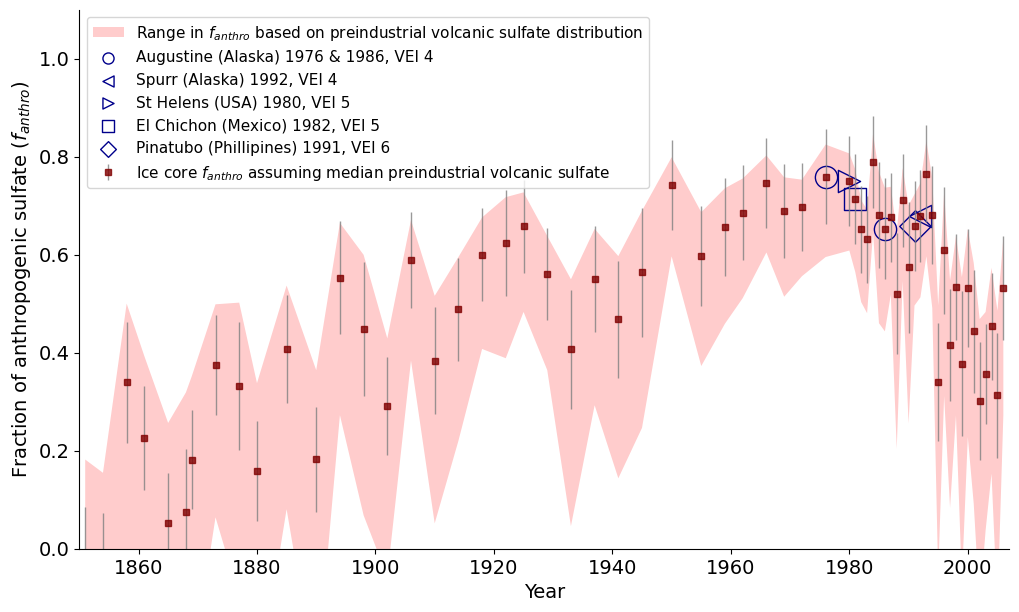

In [54]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=[12,7],dpi=100) # switch DPI to 600 for higher quality figure
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.1)
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0)


l = 1
el = 0.5
aa = 0.8
aaa=0.05
j=14
size=4


ax.errorbar(year_ind,fanth,sigma_fanthro,fmt='s',markersize=5,
            color='maroon',ecolor='gray',linewidth=l,label='Ice core $f_{anthro}$ assuming median preindustrial volcanic sulfate',alpha=0.8)

ax.fill_between(year_ind,fanth_2pt5,fanth_97pt5,linewidth=0,
              color='red',alpha=0.2,label='Range in $f_{anthro}$ based on preindustrial volcanic sulfate distribution')
ax.scatter(eruptyrs[0],eruptfrac[0],marker='o',s=size**4,color='#FF000000',edgecolor='darkblue')
#            label='Augustine (Alaska) 1976 & 1986, VEI 4')
ax.scatter(eruptyrs[1],eruptfrac[1],marker='<',s=size**4,color='#FF000000',edgecolor='darkblue')
#            label='Spurr (Alaska) 1992, VEI 4')
ax.scatter(eruptyrs[2],eruptfrac[2],marker='>',s=size**4,color='#FF000000',edgecolor='darkblue')
#            label='St Helens (USA) 1980, VEI 5')
ax.scatter(eruptyrs[3],eruptfrac[3],marker='s',s=size**4,color='#FF000000',edgecolor='darkblue')
#            label='El Chichon (Mexico) 1982, VEI 5')
ax.scatter(eruptyrs[4],eruptfrac[4],marker='o',s=size**4,color='#FF000000',edgecolor='darkblue')
ax.scatter(eruptyrs[5],eruptfrac[5],marker='D',s=size**4,color='#FF000000',edgecolor='darkblue')
#            label='Pinatubo (Phillipines) 1991, VEI 6')

ax.scatter(eruptyrs[0],eruptfrac[0]*4,marker='o',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='Augustine (Alaska) 1976 & 1986, VEI 4')
ax.scatter(eruptyrs[1],eruptfrac[1]*4,marker='<',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='Spurr (Alaska) 1992, VEI 4')
ax.scatter(eruptyrs[2],eruptfrac[2]*4,marker='>',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='St Helens (USA) 1980, VEI 5')
ax.scatter(eruptyrs[3],eruptfrac[3]*4,marker='s',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='El Chichon (Mexico) 1982, VEI 5')
ax.scatter(eruptyrs[4],eruptfrac[4]*4,marker='o',s=size**3,color='#FF000000',edgecolor='darkblue')
ax.scatter(eruptyrs[5],eruptfrac[5]*4,marker='D',s=size**3,color='#FF000000',edgecolor='darkblue',
           label='Pinatubo (Phillipines) 1991, VEI 6')


# ax.hlines(xmin=1850,xmax=2007,y=0.5)
ax.set_xlim([1850,2007])
ax.set_ylim([0,1.1])

ax.set_ylabel('Fraction of anthropogenic sulfate ($f_{anthro}$)',fontsize=j)
ax.set_xlabel('Year',fontsize=j)
ax.tick_params(axis='x', labelsize= j)
ax.tick_params(axis='y', labelsize= j)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', fontsize= j-3)
ax.set_ylim([0,1.1])

# fig.savefig('./Fig4.pdf')


In [55]:
ceds_ice_yrs = np.zeros(len(year_ind))
ceds_ice_na_emiss = np.zeros(len(year_ind))
ceds_ice_naeu_emiss = np.zeros(len(year_ind))
ceds_ice_eu_emiss = np.zeros(len(year_ind))

i = 0
j = 0

while i < len(ceds_yrs) and j < len(year_ind):
        if ceds_yrs[i] > year_ind[j]:
#             print('1',i,j)
            j = j+1
        elif ceds_yrs[i] < year_ind[j]:
#             print('2',i,j)
            i = i + 1
        elif ceds_yrs[i] == year_ind[j]:
#             print('3',i,j)
            ceds_ice_yrs[j] = ceds_yrs[i]
            ceds_ice_na_emiss[j] = na_emiss_ceds[i]
            ceds_ice_eu_emiss[j] = eu_emiss_ceds[i]
            ceds_ice_naeu_emiss[j] = na_eu_su_emiss_ceds[i]
            i = i+1
            j = j+1
        else:
            print('error')

# Correlation analysis in Results section of Jongebloed et al. (2023) ERL

r squared of ice core vs. EU emissions 0.681841065244825
r squared of ice core vs. N. American emissions 0.5997408889735802
r squared of ice core vs. N. American + EU emissions 0.6811503172918493


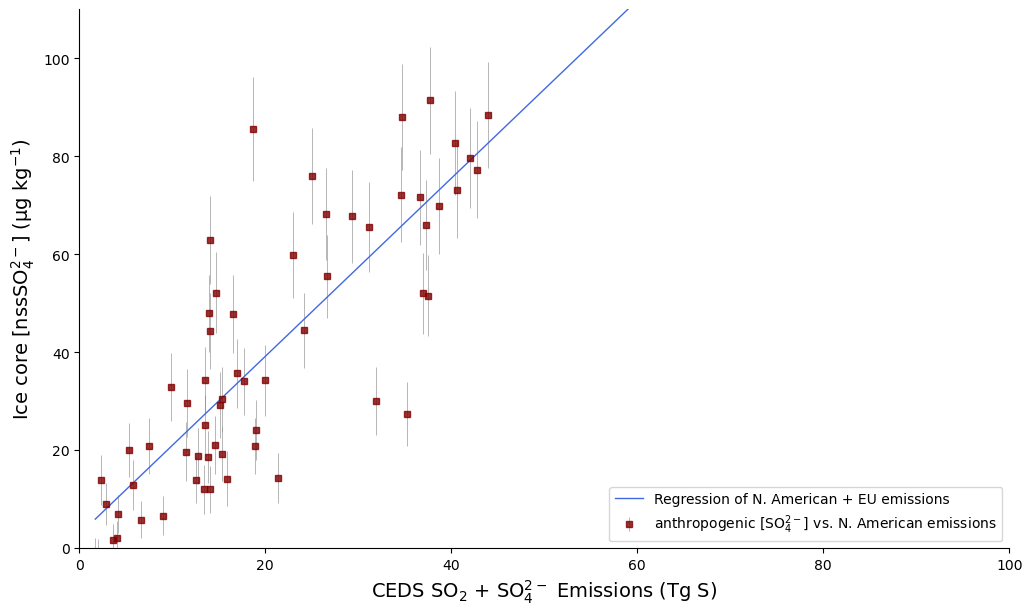

In [56]:
fig, ax = plt.subplots(figsize = [12,7])
j=14
ax.set_ylabel('Ice core [nssSO$_4^{2-}$] (µg kg$^{-1}$)',fontsize=j)
ax.set_xlabel('CEDS SO$_2$ + SO$_4^{2-}$ Emissions (Tg S)',fontsize=j)

ax.set_xlim([0,100])
ax.set_ylim([0,110])

slope_na_emiss, int_na_emiss, r_na_emiss, p_na_emiss, stderr_na_emiss = stats.linregress(ceds_ice_na_emiss,anthSO4)

slope_eu_emiss, int_eu_emiss, r_eu_emiss, p_eu_emiss, stderr_eu_emiss = stats.linregress(ceds_ice_eu_emiss,anthSO4)
slope_naeu_emiss,int_naeu_emiss,r_naeu_emiss,p_naeu_emiss,stderr_naeu_emiss = stats.linregress(ceds_ice_naeu_emiss,
                                                                                               anthSO4)

ax.errorbar(ceds_ice_eu_emiss*1e-9,anthSO4,sigma_anthro,fmt='s',markersize=size,zorder=2,
            color='maroon',ecolor='gray',linewidth=0.5,
            label='anthropogenic [SO$_4^{2-}$] vs. N. American emissions',alpha=0.8)
# ax.errorbar(ceds_ice_naeu_emiss*1e-9,anthSO4,sigma_anth,fmt='s',markersize=size,zorder=2,
#             color='darkblue',ecolor='gray',linewidth=0.5,
#             label='anthropogenic [SO$_4^{2-}$] vs. N. American + EU emissions',alpha=0.8)

xx_ceds_na = np.linspace(np.min(ceds_ice_na_emiss),np.max(ceds_ice_na_emiss)+ 2*np.std(ceds_ice_na_emiss),10)
xx_ceds_eu = np.linspace(np.min(ceds_ice_eu_emiss),np.max(ceds_ice_eu_emiss)+ 2*np.std(ceds_ice_eu_emiss),10)
xx_ceds_naeu = np.linspace(np.min(ceds_ice_naeu_emiss),np.max(ceds_ice_naeu_emiss)+ 2*np.std(ceds_ice_na_emiss),10)

# ax.plot(xx_ceds_na*1e-9,xx_ceds_na*slope_na_emiss+int_na_emiss,linewidth=1,color='tab:red',
#         label = 'Regression of N. American emissions')
ax.plot(xx_ceds_eu*1e-9,xx_ceds_eu*slope_eu_emiss+int_eu_emiss,linewidth=1,color='royalblue',
        label = 'Regression of N. American + EU emissions')

ax.legend(loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print('r squared of ice core vs. EU emissions',r_eu_emiss**2)
print('r squared of ice core vs. N. American emissions',r_na_emiss**2)
print('r squared of ice core vs. N. American + EU emissions',r_naeu_emiss**2)

In [57]:
top_of_core_emiss = na_eu_su_emiss_ceds[146:157]
earlier_emiss = na_eu_su_emiss_ceds[68:80]

# top_of_core_anthdep = recon_anth_dep[146:157]
# earlier_anthdep = recon_anth_dep[68:80]

# top_of_core_icedep = anthSO4_dep_mg_m2[50:]
# earlier_icedep = anthSO4_dep_mg_m2[18:22]
year_ind[18:22]

Float64Index([1918.0, 1922.0, 1925.0, 1929.0], dtype='float64', name='first_year')

In [58]:
print('mean difference between lower end and median anthro sulfate fraction',np.round(np.mean(np.abs(fanth_97pt5-fanth)),2)*100)
print('mean difference between upper end and median anthro sulfate fraction',np.round(np.mean(np.abs(fanth_2pt5-fanth)),2)*100)
print('mean difference between upper and lower end  anthro sulfate fraction',np.round(np.mean(np.abs(fanth_2pt5-fanth_97pt5)),2)*100)

print('std difference between lower end and median anthro sulfate fraction',np.round(np.std(np.abs(fanth_97pt5-fanth)),2)*100)
print('std difference between upper end and median anthro sulfate fraction',np.round(np.std(np.abs(fanth_2pt5-fanth)),2)*100)
print('stddifference between upper and lower end  anthro sulfate fraction',np.round(np.std(np.abs(fanth_2pt5-fanth_97pt5)),2)*100)


mean difference between lower end and median anthro sulfate fraction 28.999999999999996
mean difference between upper end and median anthro sulfate fraction 12.0
mean difference between upper and lower end  anthro sulfate fraction 41.0
std difference between lower end and median anthro sulfate fraction 13.0
std difference between upper end and median anthro sulfate fraction 5.0
stddifference between upper and lower end  anthro sulfate fraction 18.0


# Figure S1 from Jongebloed et al. (2023) ERL

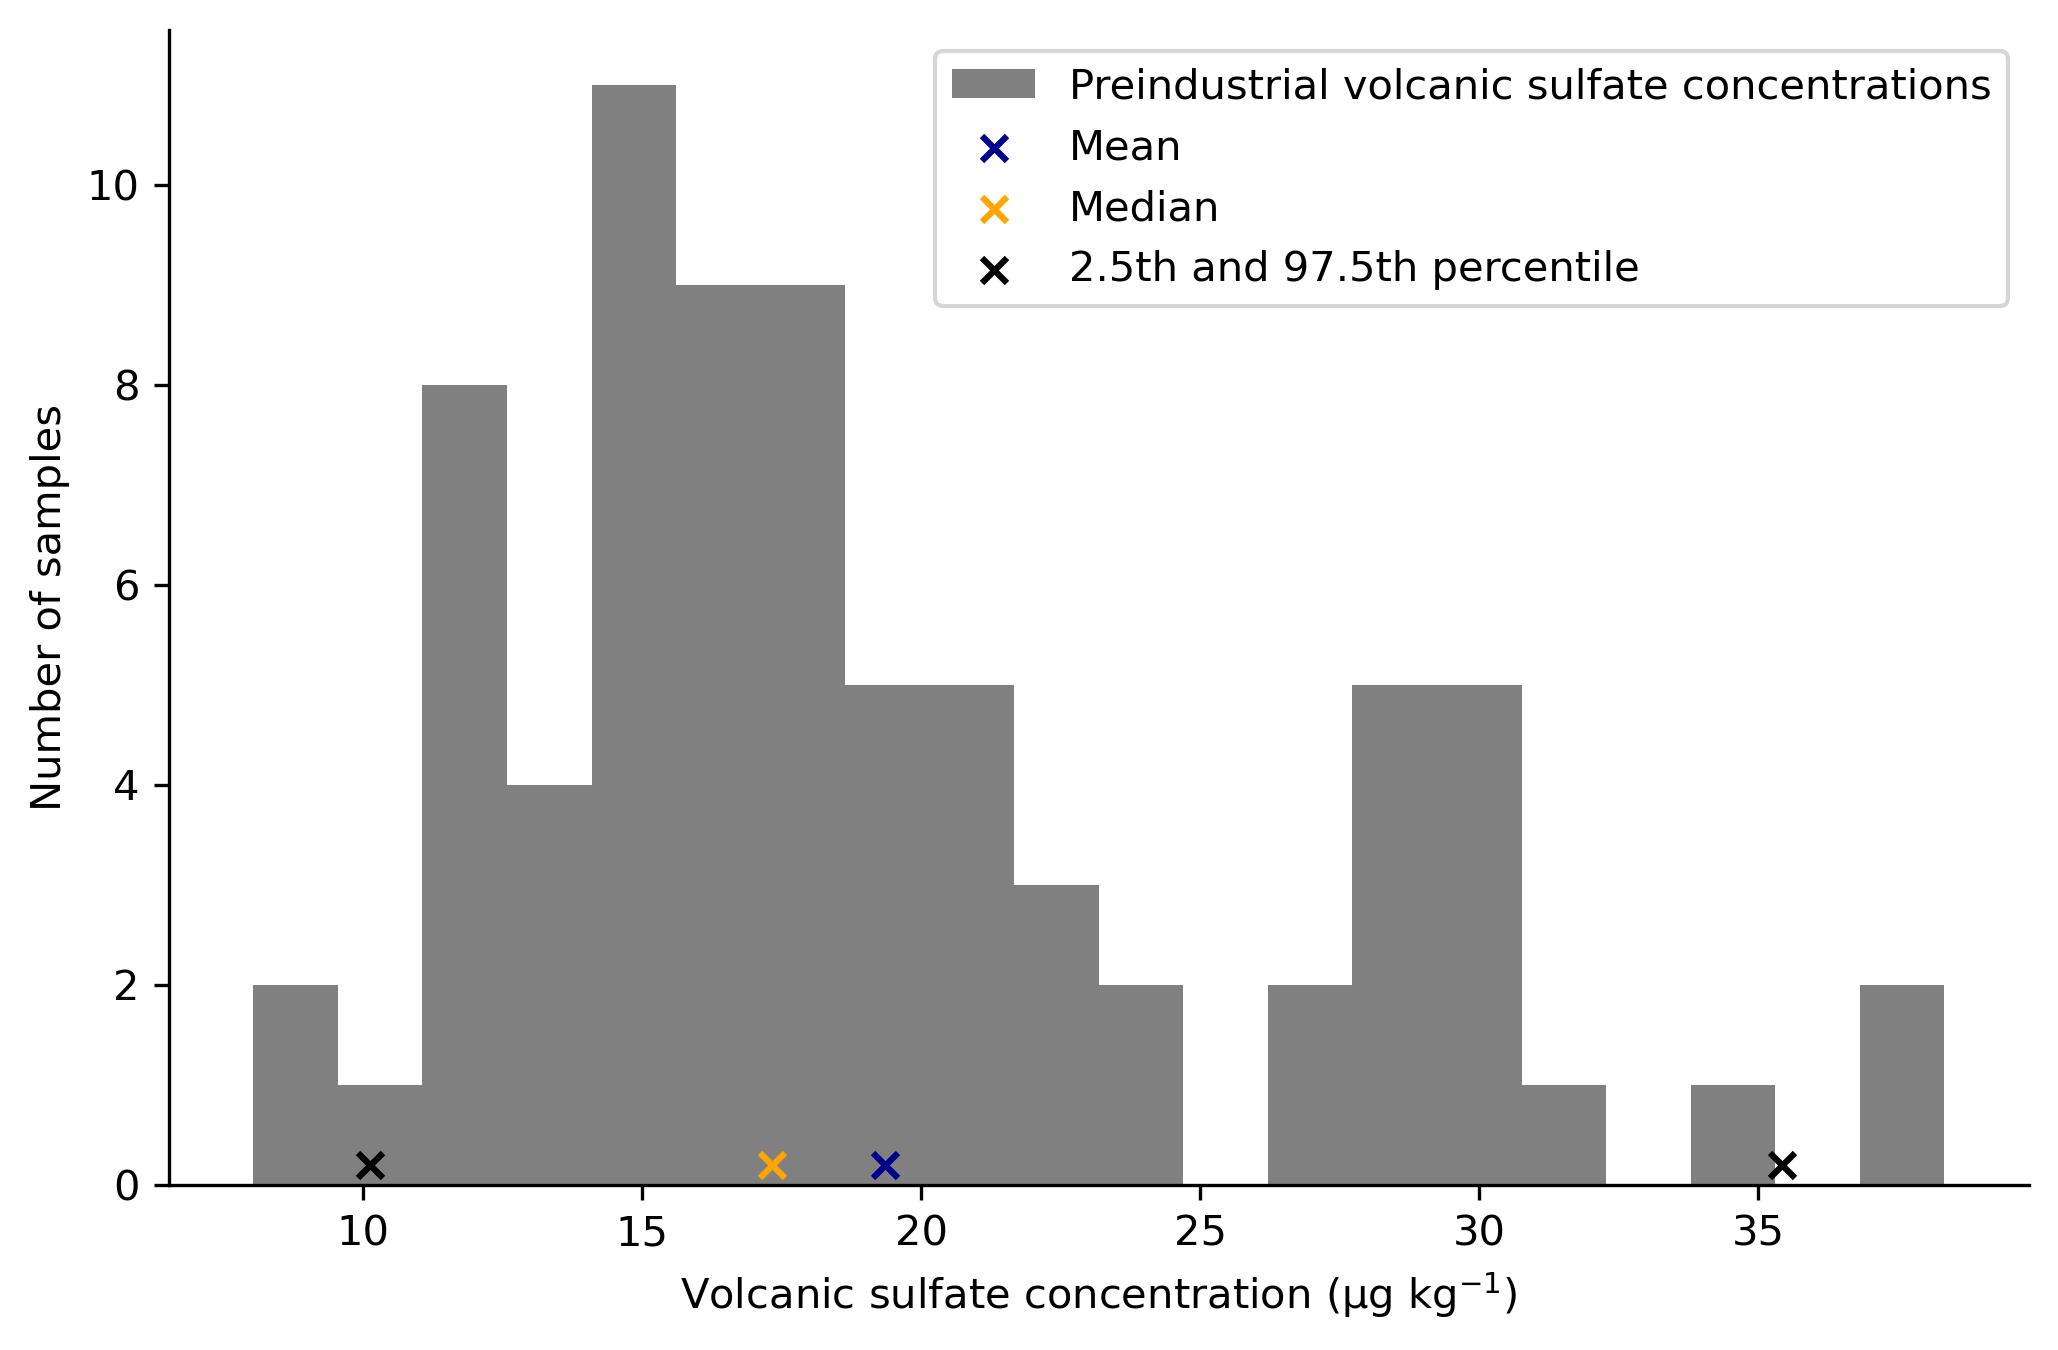

In [59]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=[8,5],dpi=300)

ax.hist(volcSO4_pre,bins=20,color='gray',label='Preindustrial volcanic sulfate concentrations')
ax.scatter(np.mean(volcSO4_pre),0.2,color = 'darkblue', marker = 'x',
           label='Mean')
ax.scatter(np.median(volcSO4_pre),0.2,color = 'orange', marker = 'x',
           label='Median')
ax.scatter(np.percentile(volcSO4_pre,97.5),0.2,color = 'k',marker = 'x',
           label='2.5th and 97.5th percentile')
ax.scatter(np.percentile(volcSO4_pre,2.5),0.2,color = 'k',marker = 'x') 
#label='2.5th and 97.5th percentile preindustrial volcanic sulfate concentration')

ax.set_xlabel('Volcanic sulfate concentration (µg kg$^{-1}$)')
ax.set_ylabel('Number of samples')
ax.legend(loc='upper right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Printing various numbers stated in text of Jongebloed et al. (2023) ERL

In [60]:
ice_nssSO4_pre       = np.mean(nssSO4_pre)
ice_nssSO4_1850_1900 = np.mean(nssSO4_ind.values[2:14])
ice_nssSO4_1960_1990 = np.mean(nssSO4_ind.values[29:45])
ice_nssSO4_1995_2006 = np.mean(nssSO4_ind.values[48:])

table = [['source','preindustrial','1850 to 1900 conc','1960 to 1990 conc','1995 to 2006 conc'],
         ['Ice core nssSO4',np.round(ice_nssSO4_pre,2),np.round(ice_nssSO4_1850_1900,2),np.round(ice_nssSO4_1960_1990,2),np.round(ice_nssSO4_1995_2006,2)]]

print('     NSSSO4')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid'))


ice_nssSO4_pre_std       = np.std(nssSO4_pre)
ice_nssSO4_1850_1900_std = np.std(nssSO4_ind.values[2:14])
ice_nssSO4_1960_1990_std = np.std(nssSO4_ind.values[29:45])
ice_nssSO4_1995_2006_std = np.std(nssSO4_ind.values[48:])

table = [['source','preindustrial','1850 to 1900 conc','1960 to 1990 conc','1995 to 2006 conc'],
         ['Ice core nssSO4',np.round(ice_nssSO4_pre_std,2),np.round(ice_nssSO4_1850_1900_std,2),np.round(ice_nssSO4_1960_1990_std,2),np.round(ice_nssSO4_1995_2006_std,2)]]

print('     std NSSSO4')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid'))

# Use Cole-Dai 2013 data instead of our measurements
ice_nssSO4_pre       = np.mean(nssSO4_1yr[nssSO4_1yr.index<1850])
ice_nssSO4_1850_1900 = np.mean((nssSO4_1yr[(nssSO4_1yr.index>1850)&(nssSO4_1yr.index<1900)]))
ice_nssSO4_1960_1990 = np.mean((nssSO4_1yr[(nssSO4_1yr.index>1965)&(nssSO4_1yr.index<1976)]))
ice_nssSO4_1995_2006 = np.mean((nssSO4_1yr[(nssSO4_1yr.index>1995)&(nssSO4_1yr.index<2006)]))

table = [['source','preindustrial','1850 to 1900 conc','1965 to 1976 conc','1995 to 2006 conc'],
         ['Ice core nssSO4',np.round(ice_nssSO4_pre,2),np.round(ice_nssSO4_1850_1900,2),np.round(ice_nssSO4_1960_1990,2),np.round(ice_nssSO4_1995_2006,2)]]

print('     NSSSO4')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid'))


ice_nssSO4_pre_std       = np.std(nssSO4_1yr[nssSO4_1yr.index<1850])
ice_nssSO4_1850_1900_std = np.std((nssSO4_1yr[(nssSO4_1yr.index>1850)&(nssSO4_1yr.index<1900)]))
ice_nssSO4_1960_1990_std = np.std((nssSO4_1yr[(nssSO4_1yr.index>1965)&(nssSO4_1yr.index<1976)]))
ice_nssSO4_1995_2006_std = np.std((nssSO4_1yr[(nssSO4_1yr.index>1995)&(nssSO4_1yr.index<2006)]))

table = [['source','preindustrial','1850 to 1900 conc','1965 to 1976 conc','1995 to 2006 conc'],
         ['Ice core nssSO4',np.round(ice_nssSO4_pre_std,2),np.round(ice_nssSO4_1850_1900_std,2),np.round(ice_nssSO4_1960_1990_std,2),np.round(ice_nssSO4_1995_2006_std,2)]]

print('     std NSSSO4')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid'))

     NSSSO4
╒═════════════════╤═════════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│ source          │   preindustrial │   1850 to 1900 conc │   1960 to 1990 conc │   1995 to 2006 conc │
╞═════════════════╪═════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ Ice core nssSO4 │           28.99 │               41.71 │               97.85 │               53.19 │
╘═════════════════╧═════════════════╧═════════════════════╧═════════════════════╧═════════════════════╛
     std NSSSO4
╒═════════════════╤═════════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│ source          │   preindustrial │   1850 to 1900 conc │   1960 to 1990 conc │   1995 to 2006 conc │
╞═════════════════╪═════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ Ice core nssSO4 │            7.66 │                8.75 │               21.12 │               13.19 │
╘═════════════════╧═════════════════

/home/disk/p/ujongebl/miniconda3/envs/pymc_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [61]:
ice_fanth_1850_1900 = np.mean(fanth.values[2:14])
ice_fanth_1960_1990 = np.mean(np.hstack([fanth.values[29:33],fanth.values[37:40],fanth.values[41:45]]))
ice_fanth_1995_2006 = np.mean(fanth.values[48:])

ice_fbio_1850_1900 = np.mean(fbio_ind.values[2:14])
ice_fbio_1960_1990 = np.mean(np.hstack([fbio_ind.values[29:33],fbio_ind.values[37:40],fbio_ind.values[41:45]]))
ice_fbio_1995_2006 = np.mean(fbio_ind.values[48:])

ice_fvolc_1850_1900 = np.mean(fvolc_ind.values[2:14])
ice_fvolc_1960_1990 = np.mean(np.hstack([fvolc_ind.values[29:33],fvolc_ind.values[37:40],fvolc_ind.values[41:45]]))
ice_fvolc_1995_2006 = np.mean(fvolc_ind.values[48:])

ice_fnat_1850_1900 = np.mean(fvolc_ind.values[2:14] + fbio_ind.values[2:14])
ice_fnat_1960_1990 = np.mean(np.hstack([fvolc_ind.values[29:33],fvolc_ind.values[37:40],fvolc_ind.values[41:45]]) + 
                            np.hstack([fbio_ind.values[29:33],fbio_ind.values[37:40],fbio_ind.values[41:45]]))
ice_fnat_1995_2006 = np.mean(fvolc_ind.values[48:] + fbio_ind.values[48:])

sigma_ice_fanth_1850_1900 = np.std(fanth.values[2:14])
sigma_ice_fanth_1960_1990 = np.std(np.hstack([fanth.values[29:33],fanth.values[37:40],fanth.values[41:45]]))
sigma_ice_fanth_1995_2006 = np.std(fanth.values[48:])

sigma_ice_fbio_1850_1900 = np.std(fbio_ind.values[2:14])
sigma_ice_fbio_1960_1990 = np.std(np.hstack([fbio_ind.values[29:33],fbio_ind.values[37:40],fbio_ind.values[41:45]]))
sigma_ice_fbio_1995_2006 = np.std(fbio_ind.values[48:])

sigma_ice_fvolc_1850_1900 = np.std(fvolc_ind.values[2:14])
sigma_ice_fvolc_1960_1990 = np.std(np.hstack([fvolc_ind.values[29:33],fvolc_ind.values[37:40],fvolc_ind.values[41:45]]))
sigma_ice_fvolc_1995_2006 = np.std(fvolc_ind.values[48:])

sigma_ice_fnat_1850_1900 = np.std(fvolc_ind.values[2:14] + fbio_ind.values[2:14])
sigma_ice_fnat_1960_1990 = np.std(np.hstack([fvolc_ind.values[29:33],fvolc_ind.values[37:40],fvolc_ind.values[41:45]]) + 
                            np.hstack([fbio_ind.values[29:33],fbio_ind.values[37:40],fbio_ind.values[41:45]]))
sigma_ice_fnat_1995_2006 = np.std(fvolc_ind.values[48:] + fbio_ind.values[48:])


table = [['source','1850 to 1900 percent','1960 to 1990 percent','1995 to 2006 percent'],
         ['anth',np.round(ice_fanth_1850_1900,2)*1e2,np.round(ice_fanth_1960_1990,2)*1e2,np.round(ice_fanth_1995_2006,2)*1e2],
         ['bio',np.round(ice_fbio_1850_1900,2)*1e2,np.round(ice_fbio_1960_1990,2)*1e2,np.round(ice_fbio_1995_2006,2)*1e2],
         ['volc',np.round(ice_fvolc_1850_1900,2)*1e2,np.round(ice_fvolc_1960_1990,2)*1e2,np.round(ice_fvolc_1995_2006,2)*1e2],
         ['nat',np.round(ice_fnat_1850_1900,2)*1e2,np.round(ice_fnat_1960_1990,2)*1e2,np.round(ice_fnat_1995_2006,2)*1e2]]


print('     ICE CORE')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid'))

table = [['source','1850 to 1900 sigma','1960 to 1990 sigma','1995 to 2006 sigma'],
         ['anth',np.round(sigma_ice_fanth_1850_1900,2)*1e2,np.round(sigma_ice_fanth_1960_1990,2)*1e2,np.round(sigma_ice_fanth_1995_2006,2)*1e2],
         ['bio',np.round(sigma_ice_fbio_1850_1900,2)*1e2,np.round(sigma_ice_fbio_1960_1990,2)*1e2,np.round(sigma_ice_fbio_1995_2006,2)*1e2],
         ['volc',np.round(sigma_ice_fvolc_1850_1900,2)*1e2,np.round(sigma_ice_fvolc_1960_1990,2)*1e2,np.round(sigma_ice_fvolc_1995_2006,2)*1e2],
         ['natural',np.round(sigma_ice_fnat_1850_1900,2)*1e2,np.round(sigma_ice_fnat_1960_1990,2)*1e2,np.round(sigma_ice_fnat_1995_2006,2)*1e2]]


print('     ICE CORE SIGMAS')
print(tabulate(table,headers='firstrow',tablefmt='fancy_grid'))


     ICE CORE
╒══════════╤════════════════════════╤════════════════════════╤════════════════════════╕
│ source   │   1850 to 1900 percent │   1960 to 1990 percent │   1995 to 2006 percent │
╞══════════╪════════════════════════╪════════════════════════╪════════════════════════╡
│ anth     │                     28 │                     67 │                     45 │
├──────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ bio      │                     29 │                     13 │                     20 │
├──────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ volc     │                     43 │                     20 │                     34 │
├──────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ nat      │                     72 │                     33 │                     55 │
╘══════════╧════════════════════════╧════════════════════════╧════════════════════════╛
     ICE CORE SIGM

In [62]:
top_of_core_emiss = na_eu_su_emiss_ceds[146:157]
earlier_emiss = na_eu_su_emiss_ceds[68:80]

top_of_core_anth_conc = anthSO4.values[50:]
earlier_anth_conc = anthSO4.values[18:22]
year_ind[18:22]

x1, p_emiss = stats.ttest_ind(top_of_core_emiss, 
                                earlier_emiss, axis=0, equal_var=True, nan_policy='omit')

x2, p_ice_core = stats.ttest_ind(top_of_core_anth_conc, 
                                earlier_anth_conc, axis=0, equal_var=True, nan_policy='omit')

print('Early years:',ceds_yrs[68],ceds_yrs[80])
print('Top of core years',ceds_yrs[146],ceds_yrs[156])
print('-----------------------------------------------------------')
print('Emissions early (Gg)',np.round(np.mean(earlier_emiss*1e-9),2))
print('Emissions top   (Gg)',np.round(np.mean(top_of_core_emiss*1e-9),2))
print('p value difference',p_emiss)
print('-----------------------------------------------------------')
print('Conc ice core early (µg kg-1)',np.round(np.mean(earlier_anth_conc),2))
print('Conc ice core top of core (µg kg-1)',np.round(np.mean(top_of_core_anth_conc),2))
print('p value difference',p_ice_core)

Early years: 1918.0 1930.0
Top of core years 1996.0 2006.0
-----------------------------------------------------------
Emissions early (Gg) 32.81
Emissions top   (Gg) 35.45
p value difference 0.09472289022925948
-----------------------------------------------------------
Conc ice core early (µg kg-1) 51.83
Conc ice core top of core (µg kg-1) 23.27
p value difference 7.444229986312006e-05


In [63]:
years_morehalf = len(fanth[fanth>0.5])
years_total = len(fanth)
max_fanth_ice = np.max(fanth)
min_fanth_ice_20thcent = np.min(fanth[fanth.index>1900])
print('years sampled',years_total)
print('years with fanth>50%',years_morehalf)
print('min 20th century fanth',min_fanth_ice_20thcent)
print('max 20th century fanth',max_fanth_ice)

years sampled 61
years with fanth>50% 35
min 20th century fanth 0.2909898666743576
max 20th century fanth 0.7892889424023486
